## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 928.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.2
    Uninstalling sentence-transformers-5.1.2:
      Successfully uninstalled sentence-transformers-5.1.2
ERROR: pip

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [1]:
# importing all the necessary libraries

# for data analysis
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess

# Word embeddings
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

# Evaluation Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# ML Models
from sklearn.ensemble import RandomForestClassifier

# Deep Learning models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set the global random seed for TensorFlow operations for reproducibility
tf.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive') # mounting the google drive

Mounted at /content/drive


## **Loading the dataset**

In [4]:
# Using Pandas to load the data from google drive. The data is available in csv format.
data_df = pd.read_csv('/content/drive/My Drive/PGP-AI-UT-Austin/Project/Data/stock_news.csv')
stock_data_df = data_df.copy() # Copying the data to preserve the original

## **Data Overview**

In [5]:
# check first 10 records
stock_data_df.head(10)

,Date,News,Open,High,Low,Close,Volume,Label
0,01-02-2019,The dollar minutes ago tumbled to 106 67 from...,38.72,39.71,38.56,39.48,130672400,1
1,01-02-2019,By Wayne Cole and Swati Pandey SYDNEY Reuters...,38.72,39.71,38.56,39.48,130672400,-1
2,01-02-2019,By Stephen Culp NEW YORK Reuters Wall Stre...,38.72,39.71,38.56,39.48,130672400,0
3,01-02-2019,By Wayne Cole SYDNEY Reuters The Australia...,38.72,39.71,38.56,39.48,130672400,-1
4,01-02-2019,Investing com Asian equities fell in morning...,38.72,39.71,38.56,39.48,130672400,1
5,01-02-2019,Bloomberg Apple Inc s Asian suppliers tu...,38.72,39.71,38.56,39.48,130672400,-1
6,01-02-2019,Investing com The Japanese yen jumped on Thu...,38.72,39.71,38.56,39.48,130672400,1
7,01-02-2019,RBC Capital reiterates its Outperform rating a...,38.72,39.71,38.56,39.48,130672400,0
8,01-02-2019,Reuters Roku Inc O ROKU said on Wednes...,38.72,39.71,38.56,39.48,130672400,1
9,01-02-2019,The tech sector NYSEARCA XLK plunges 2 3 af...,38.72,39.71,38.56,39.48,130672400,-1


In [6]:
# Check the last 10 records
stock_data_df.tail(10)

,Date,News,Open,High,Low,Close,Volume,Label
408,04-24-2019,By Jeffrey Dastin and Heather Somerville SAN F...,51.84,52.12,51.76,51.79,70162400,1
409,04-24-2019,Investing com Wall Street was muted on Wedne...,51.84,52.12,51.76,51.79,70162400,1
410,04-24-2019,By Aditya Kalra and Sudarshan Varadhan NEW DEL...,51.84,52.12,51.76,51.79,70162400,-1
411,04-24-2019,Reuters Dutch semiconductor supplier ASM I...,51.84,52.12,51.76,51.79,70162400,1
412,04-25-2019,BENGALURU Reuters Music streaming service ...,51.71,51.94,51.28,51.32,74172800,1
413,04-26-2019,By Makiko Yamazaki TOKYO Reuters Sony Corp...,51.22,51.25,50.53,51.08,74596400,1
414,04-29-2019,By Akanksha Rana and Kenneth Li Reuters Sp...,51.10,51.49,50.97,51.15,88818800,1
415,04-29-2019,shares rose 3 5 after the company s first qua...,51.10,51.49,50.97,51.15,88818800,1
416,04-29-2019,By Caroline Valetkevitch NEW YORK Reuters ...,51.10,51.49,50.97,51.15,88818800,1
417,04-29-2019,By Arjun Panchadar and Paresh Dave Reuters ...,51.10,51.49,50.97,51.15,88818800,1


In [7]:
# summary of data
stock_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    418 non-null    object 
 1   News    418 non-null    object 
 2   Open    418 non-null    float64
 3   High    418 non-null    float64
 4   Low     418 non-null    float64
 5   Close   418 non-null    float64
 6   Volume  418 non-null    int64  
 7   Label   418 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 26.3+ KB


In [8]:
# number of rows and columns
stock_data_df.shape

(418, 8)

In [9]:
# check for any missing values
stock_data_df.isnull().sum() # No null values found

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [10]:
# check for duplicates
stock_data_df.duplicated().sum() # No duplicates found

0

In [11]:
# Finding the unique values of the target variable
stock_data_df['Label'].unique()

array([ 1, -1,  0])

In [12]:
# Data stats summary
stock_data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,418.0,4.230885e+01,4.947134e+00,35.99,3.813000e+01,4.153000e+01,4.719000e+01,5.184000e+01
High,418.0,4.278732e+01,4.947413e+00,36.43,3.842000e+01,4.225000e+01,4.742750e+01,5.212000e+01
Low,418.0,4.192373e+01,4.967880e+00,35.50,3.772000e+01,4.114000e+01,4.648000e+01,5.176000e+01
Close,418.0,4.241852e+01,4.999867e+00,35.55,3.827000e+01,4.161000e+01,4.703250e+01,5.187000e+01
Volume,418.0,1.294225e+08,4.574550e+07,45448000.00,1.029072e+08,1.156272e+08,1.511252e+08,3.652488e+08
Label,418.0,3.086124e-01,9.434731e-01,-1.00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [13]:
# date range in the file
print(f'Start Date: {stock_data_df["Date"].min()}')
print(f'End Date: {stock_data_df["Date"].max()}')

# records by each month
stock_data_df['Date'] = pd.to_datetime(stock_data_df['Date']) # Convert the date column data data type to date
print(stock_data_df['Date'].dt.month.value_counts().sort_index()) # More data for January, rest are evenly spread till April

# Adding month column to the data
stock_data_df['Month'] = stock_data_df['Date'].dt.month

# Adding day of the week to the data
stock_data_df['Day_of_Week'] = stock_data_df['Date'].dt.day_name()

Start Date: 01-02-2019
End Date: 04-29-2019
Date
1    210
2     58
3     79
4     71
Name: count, dtype: int64


In [14]:
stock_data_df.head()

,Date,News,Open,High,Low,Close,Volume,Label,Month,Day_of_Week
0,2019-01-02,The dollar minutes ago tumbled to 106 67 from...,38.72,39.71,38.56,39.48,130672400,1,1,Wednesday
1,2019-01-02,By Wayne Cole and Swati Pandey SYDNEY Reuters...,38.72,39.71,38.56,39.48,130672400,-1,1,Wednesday
2,2019-01-02,By Stephen Culp NEW YORK Reuters Wall Stre...,38.72,39.71,38.56,39.48,130672400,0,1,Wednesday
3,2019-01-02,By Wayne Cole SYDNEY Reuters The Australia...,38.72,39.71,38.56,39.48,130672400,-1,1,Wednesday
4,2019-01-02,Investing com Asian equities fell in morning...,38.72,39.71,38.56,39.48,130672400,1,1,Wednesday


**Data Overview**
* The dataset contains Date, News, Open, High, Low, Close, Volume and Label.
* Data contains Date (Datetime), News (String), Open, High, Low and Close are floating point numbers. Volume field is an integer. Label seems to be a categorical column with distinct values as -1, 0 and 1
* Extracted month and Day of week from date to see if it has any correlation with Label when performing EDA
* We have 4 months of data (Jan 02 2019 till Apr 29 2019) in the dataset
* There are 418 records in the dataset.
* No nulls or duplicates found in the dataset

## **Exploratory Data Analysis**

### **Univariate Analysis**

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [15]:
# Looking at how the labels are distributed in a table
stock_data_df.groupby('Label').size()

,0
Label,
-1,141
0,7
1,270


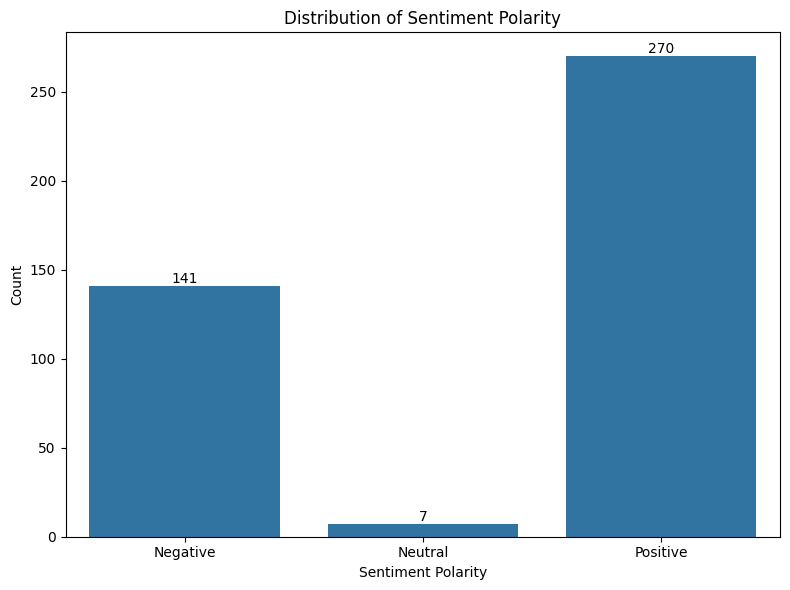

In [16]:
# Plotting the distribution of label (sentiment polarity) in the dataset
plt.figure(figsize=(8,6))
ax = sns.countplot(x='Label', data=stock_data_df)
ax.bar_label(ax.containers[0], fmt='%d')
plt.title('Distribution of Sentiment Polarity')
plt.xticks(ticks=[0,1,2], labels=['Negative', 'Neutral', 'Positive']) # Label the sentiment for better view
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Mostly the records have either positive or negative sentiments.
Neutral sentiments are minimal

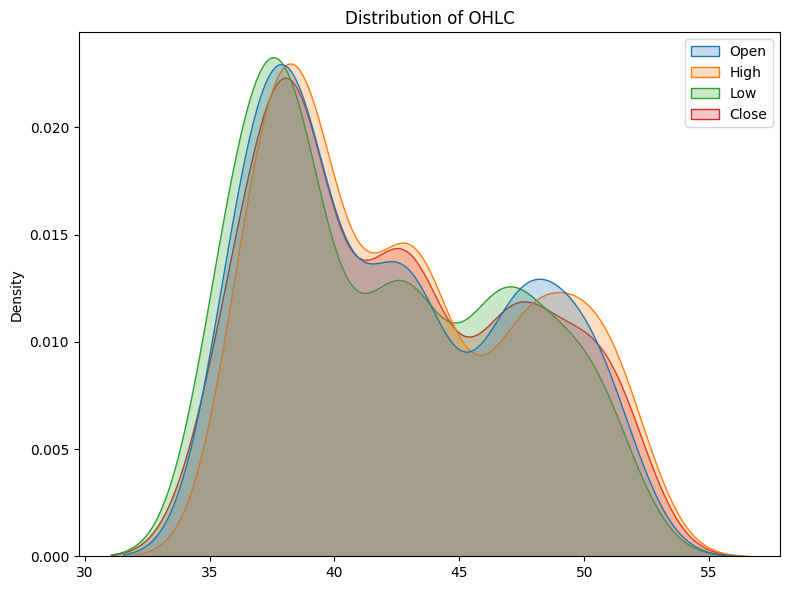

In [17]:
# Analyze the distribution of open, high, low and close columns in one chart
features = ['Open','High','Low','Close']
plt.figure(figsize=(8,6))
sns.kdeplot(data=stock_data_df[features], fill=True)
plt.title('Distribution of OHLC')
plt.tight_layout()
plt.show()

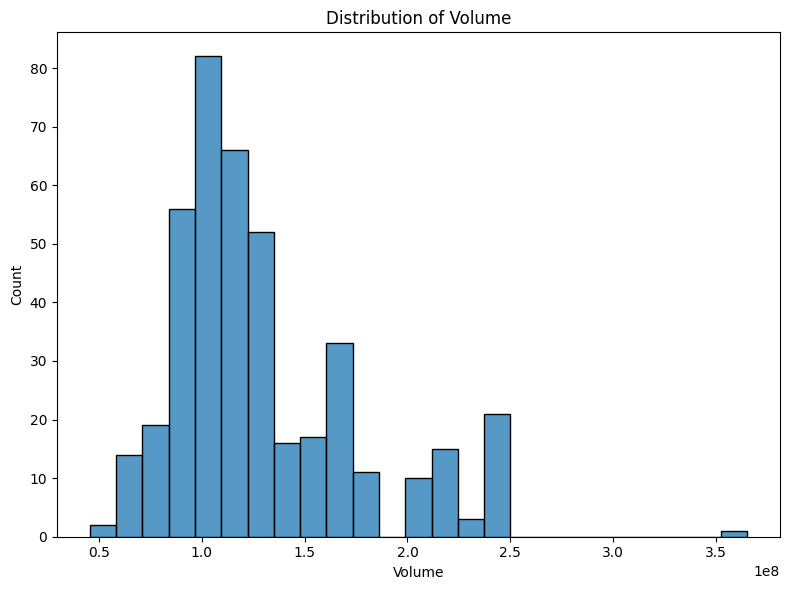

In [18]:
# Distribution of volume in the dataset
plt.figure(figsize=(8,6))
sns.histplot(data=stock_data_df, x='Volume')
plt.title('Distribution of Volume')
plt.tight_layout()
plt.show()

*   The stock's volume averages around 1e8
*   There is a right skew on the volume. There are some cases when when the volumes are above the mean as well





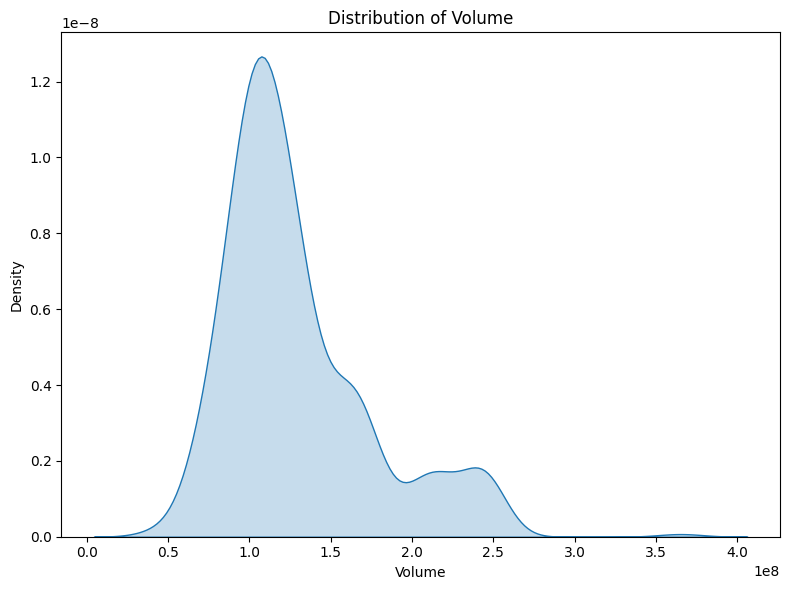

In [19]:
# kde on volume
plt.figure(figsize=(8,6))
sns.kdeplot(data=stock_data_df, x='Volume', fill=True)
plt.title('Distribution of Volume')
plt.tight_layout()
plt.show()

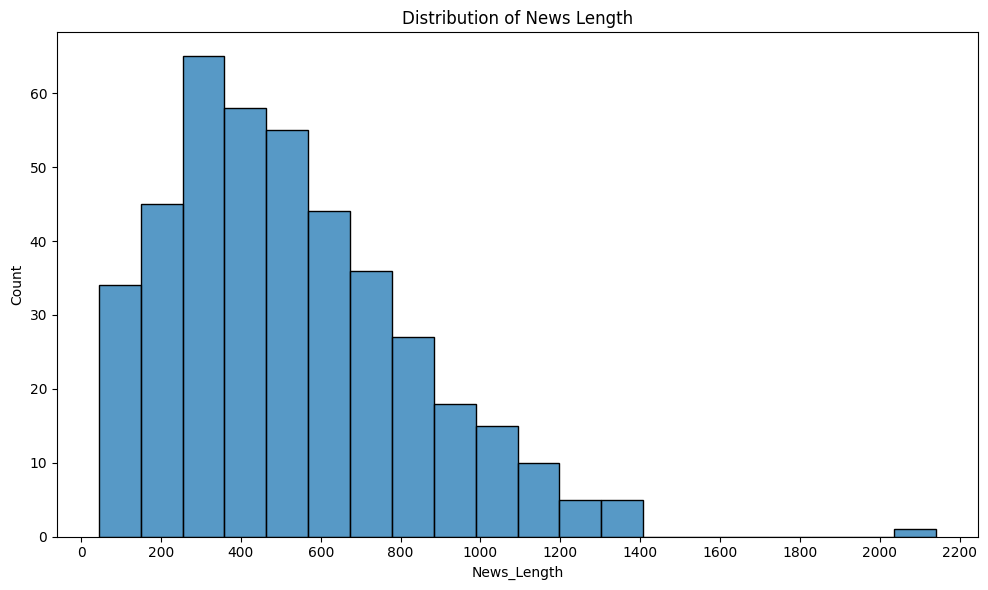

In [20]:
# Compute and check the distribution of the length of news content
# Checking how the length of news content is distributed in the data
stock_data_df['News_Length'] = stock_data_df['News'].apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(10,6))
ax = sns.histplot(data=stock_data_df, x='News_Length')
ax.set_xticks(range(0, 2300, 200))
plt.title('Distribution of News Length')
plt.tight_layout()
plt.show()

In [21]:
stock_data_df['News_Length'].describe()

,News_Length
count,418.000000
mean,525.662679
std,303.584080
min,44.000000
25%,304.250000
50%,480.000000
75%,700.500000
max,2142.000000


**Observations**
* The data is not evenly distributed. The number of neutral sentiments is way less than the positive and negative. It shows that the data is imbalanced.
* The mean number of words for the news is 525. There are some cases when the total number of words are close to 2100. This will accounted when we do the embeddings
* The Open, High, Low, and Close prices within a specific timeframe are highly positively correlated with each other, as they represent price movements within a restricted period. Market shows movements though out the day though.
* Volume also shows non normal distribution patterns as expected looking more closely related to price movements.

### **Bivariate Analysis**

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

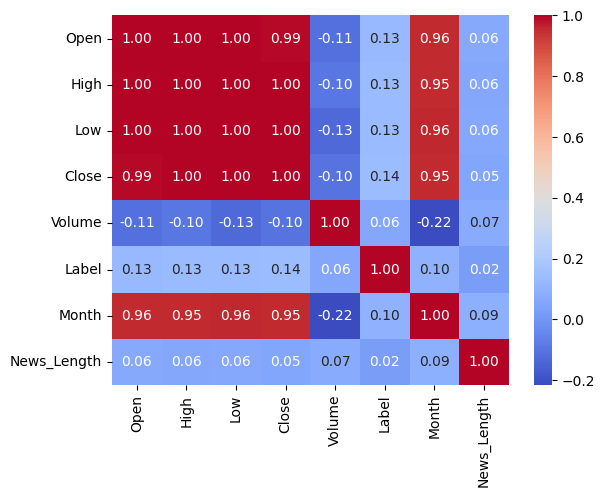

In [22]:
# Correlation
numeric_cols = stock_data_df.select_dtypes(include=['number']).columns.tolist()
sns.heatmap(stock_data_df[numeric_cols].corr(), annot=True, fmt='0.2f', cmap = 'coolwarm')
plt.show()

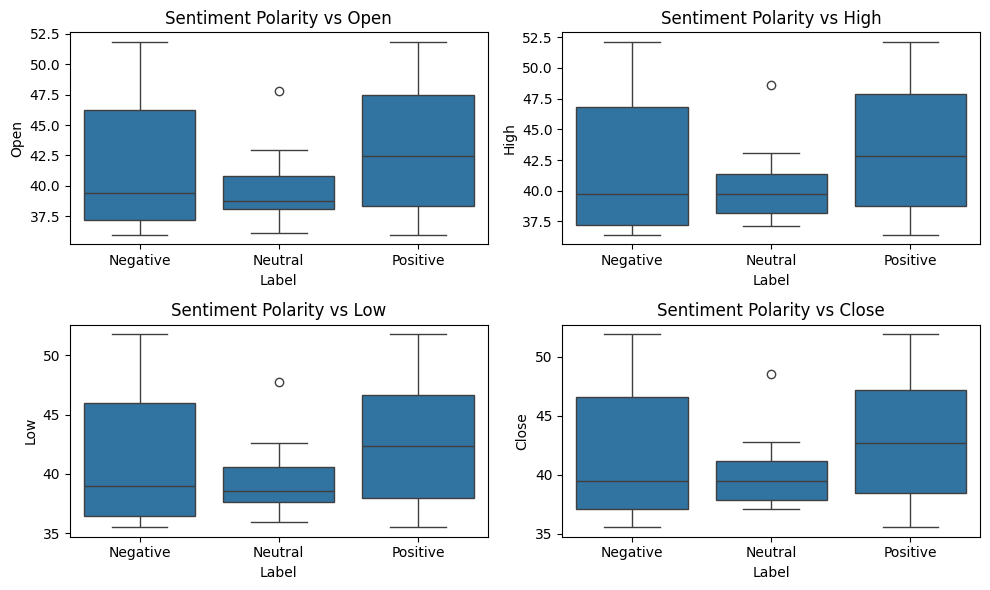

In [23]:
# Sentiment Polarity vs Price
price_cols = ['Open','High','Low','Close']
plt.figure(figsize=(10,6))
for i, price in enumerate(price_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(data=stock_data_df, x='Label', y=price)
    plt.xticks(ticks=[0,1,2], labels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Sentiment Polarity vs {price}')
plt.tight_layout()
plt.show()

**Observations**
* Not many outliers except for one when the news is identified as neutral
* The median lower (closer to first quartile) for negative sentiments shows that the data distribution is righ skewed with values mainly falling at the lower ends which is expected with a negative news
* The median for positive is somewhat in the middle and it looks like the values are evenly ditributed with a poitive market sentiment. Proabably the positive sentiment may not be the only factor making the stock price go higher

In [24]:
#3 Date vs Price
# Aggregating the data by date to create visualizations by date
stock_price_by_day = stock_data_df.groupby(['Date','Day_of_Week']).agg(
    Open = ('Open', 'mean'),
    High = ('High', 'mean'),
    Low = ('Low', 'mean'),
    Close = ('Close', 'mean'),
    Volume = ('Volume', 'mean'),
    Label = ('Label', 'mean')
    )
stock_price_by_day.reset_index(inplace=True)
stock_price_by_day.head()

,Date,Day_of_Week,Open,High,Low,Close,Volume,Label
0,2019-01-02,Wednesday,38.72,39.71,38.56,39.48,130672400.0,-0.142857
1,2019-01-03,Thursday,35.99,36.43,35.50,35.55,103544800.0,-0.405405
2,2019-01-04,Friday,36.13,37.14,35.95,37.06,111448000.0,0.187500
3,2019-01-07,Monday,37.17,37.21,36.47,36.98,109012000.0,0.076923
4,2019-01-08,Tuesday,37.39,37.96,37.13,37.69,216071600.0,0.733333


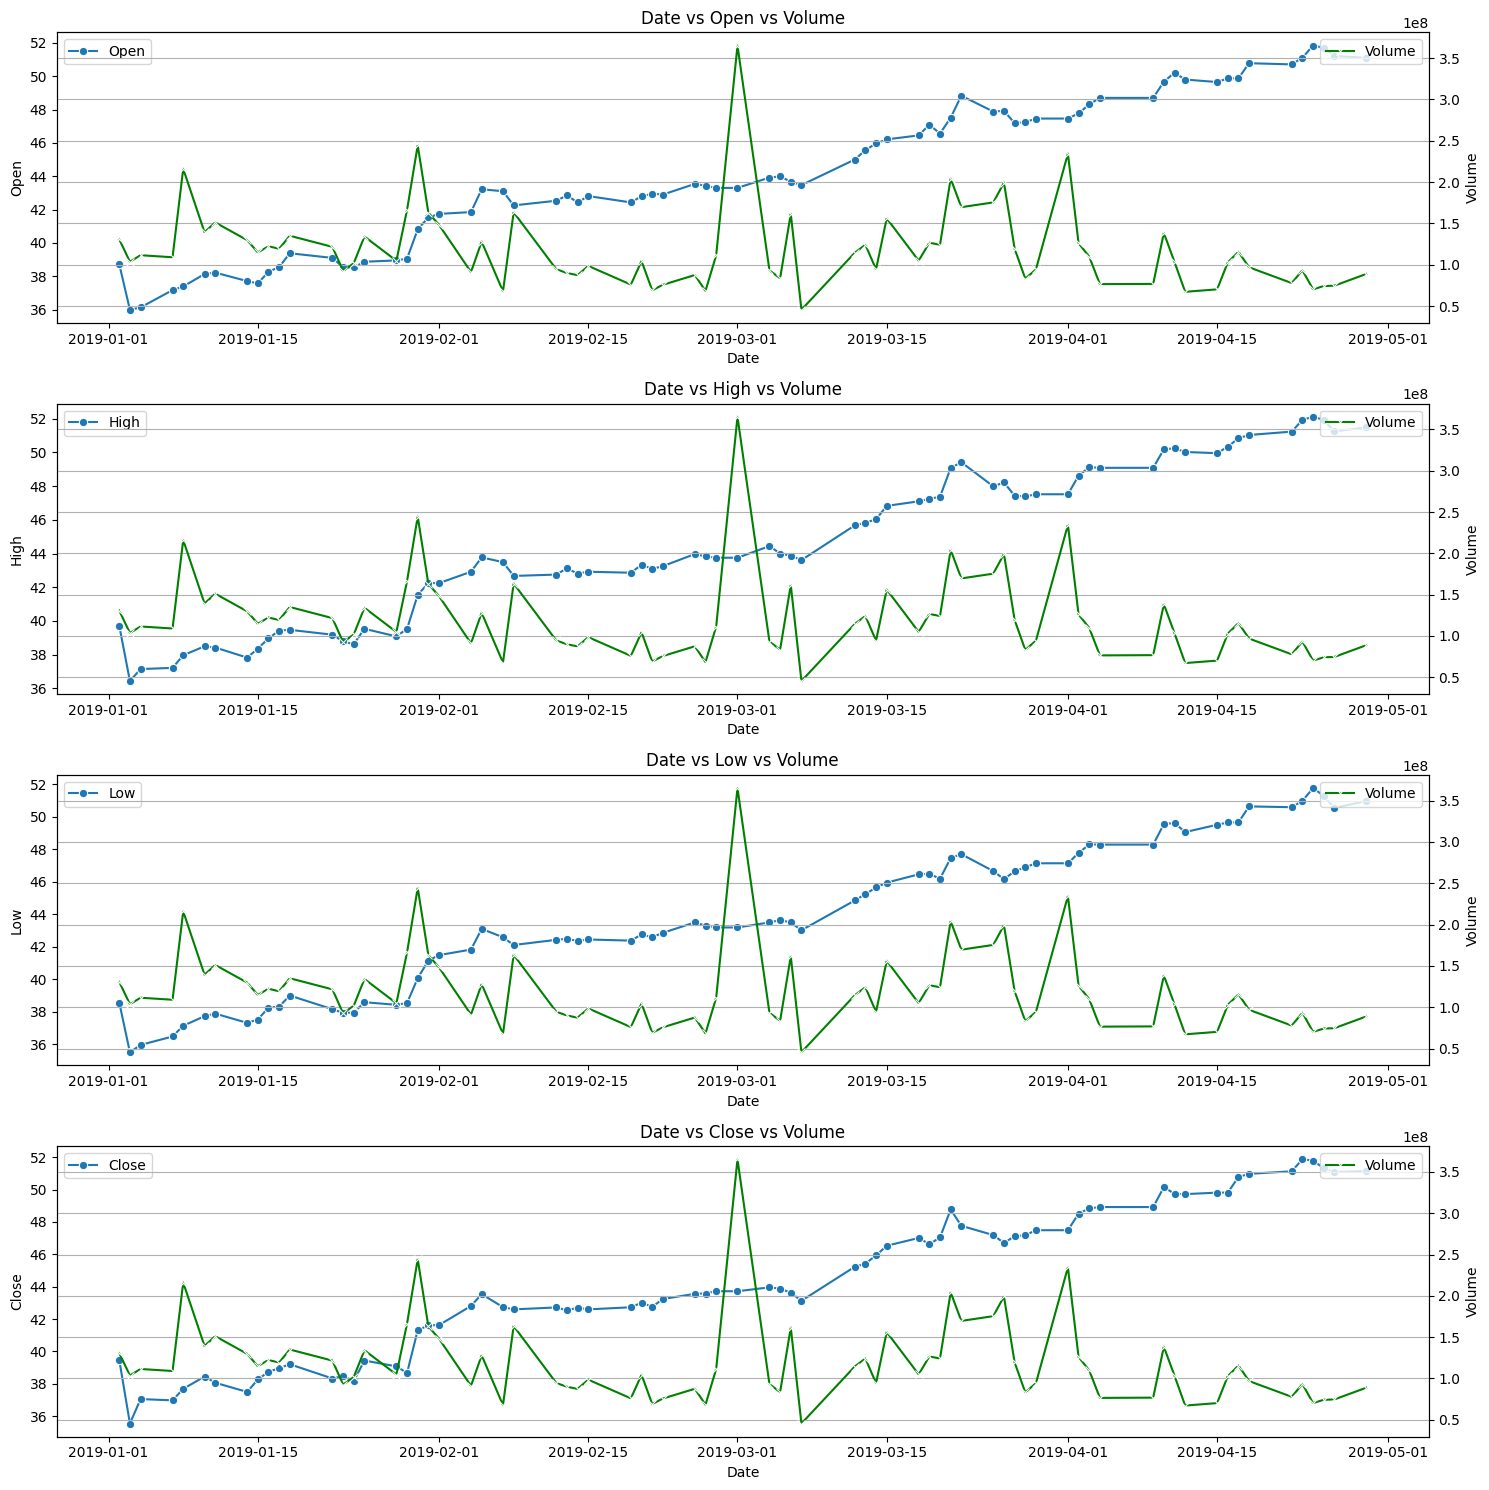

In [25]:
price_cols = ['Open','High','Low','Close']
fig, axes = plt.subplots(nrows=len(price_cols), ncols = 1, figsize=(15,15))
for i, col in enumerate(price_cols):
  sns.lineplot(data=stock_price_by_day, x='Date', y=col, ax=axes[i], marker = 'o', label=col)
  ax2 = axes[i].twinx() # Create a second y-axis for the bar chart
  sns.lineplot(data=stock_price_by_day, x='Date', y='Volume', ax=ax2, marker = 'x', color='green', label='Volume')
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel(col)
  ax2.set_ylabel('Volume')
  axes[i].set_title(f'Date vs {col} vs Volume')
  plt.grid(True)
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations**
* Overall we can see the stock prices has gone up steadily
* The corelation with volume suggests that whenever there is an increase in volume it has caused the stock price to go up in later days. When the volume went down the stock prices are either flat or gone down except for very rare cases when we can see the price going up when the volume goes down (around 2019-02-01)

In [26]:
# Order the data by day of week. This helps plotting the data chronologically against day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
stock_price_by_day['Day_of_Week'] = pd.Categorical(stock_price_by_day['Day_of_Week'], categories=day_order, ordered=True)
stock_price_by_day_sorted = stock_price_by_day.sort_values(by='Day_of_Week')
stock_price_by_day_sorted.head()

,Date,Day_of_Week,Open,High,Low,Close,Volume,Label
72,2019-04-29,Monday,51.10,51.49,50.97,51.15,88818800.0,1.000000
33,2019-02-25,Monday,43.54,43.97,43.49,43.56,87493600.0,1.000000
45,2019-03-18,Monday,46.45,47.10,46.45,47.01,104879200.0,1.000000
50,2019-03-25,Monday,47.88,47.99,46.65,47.19,175381200.0,0.272727
21,2019-02-04,Monday,41.85,42.92,41.82,42.81,91062800.0,0.500000


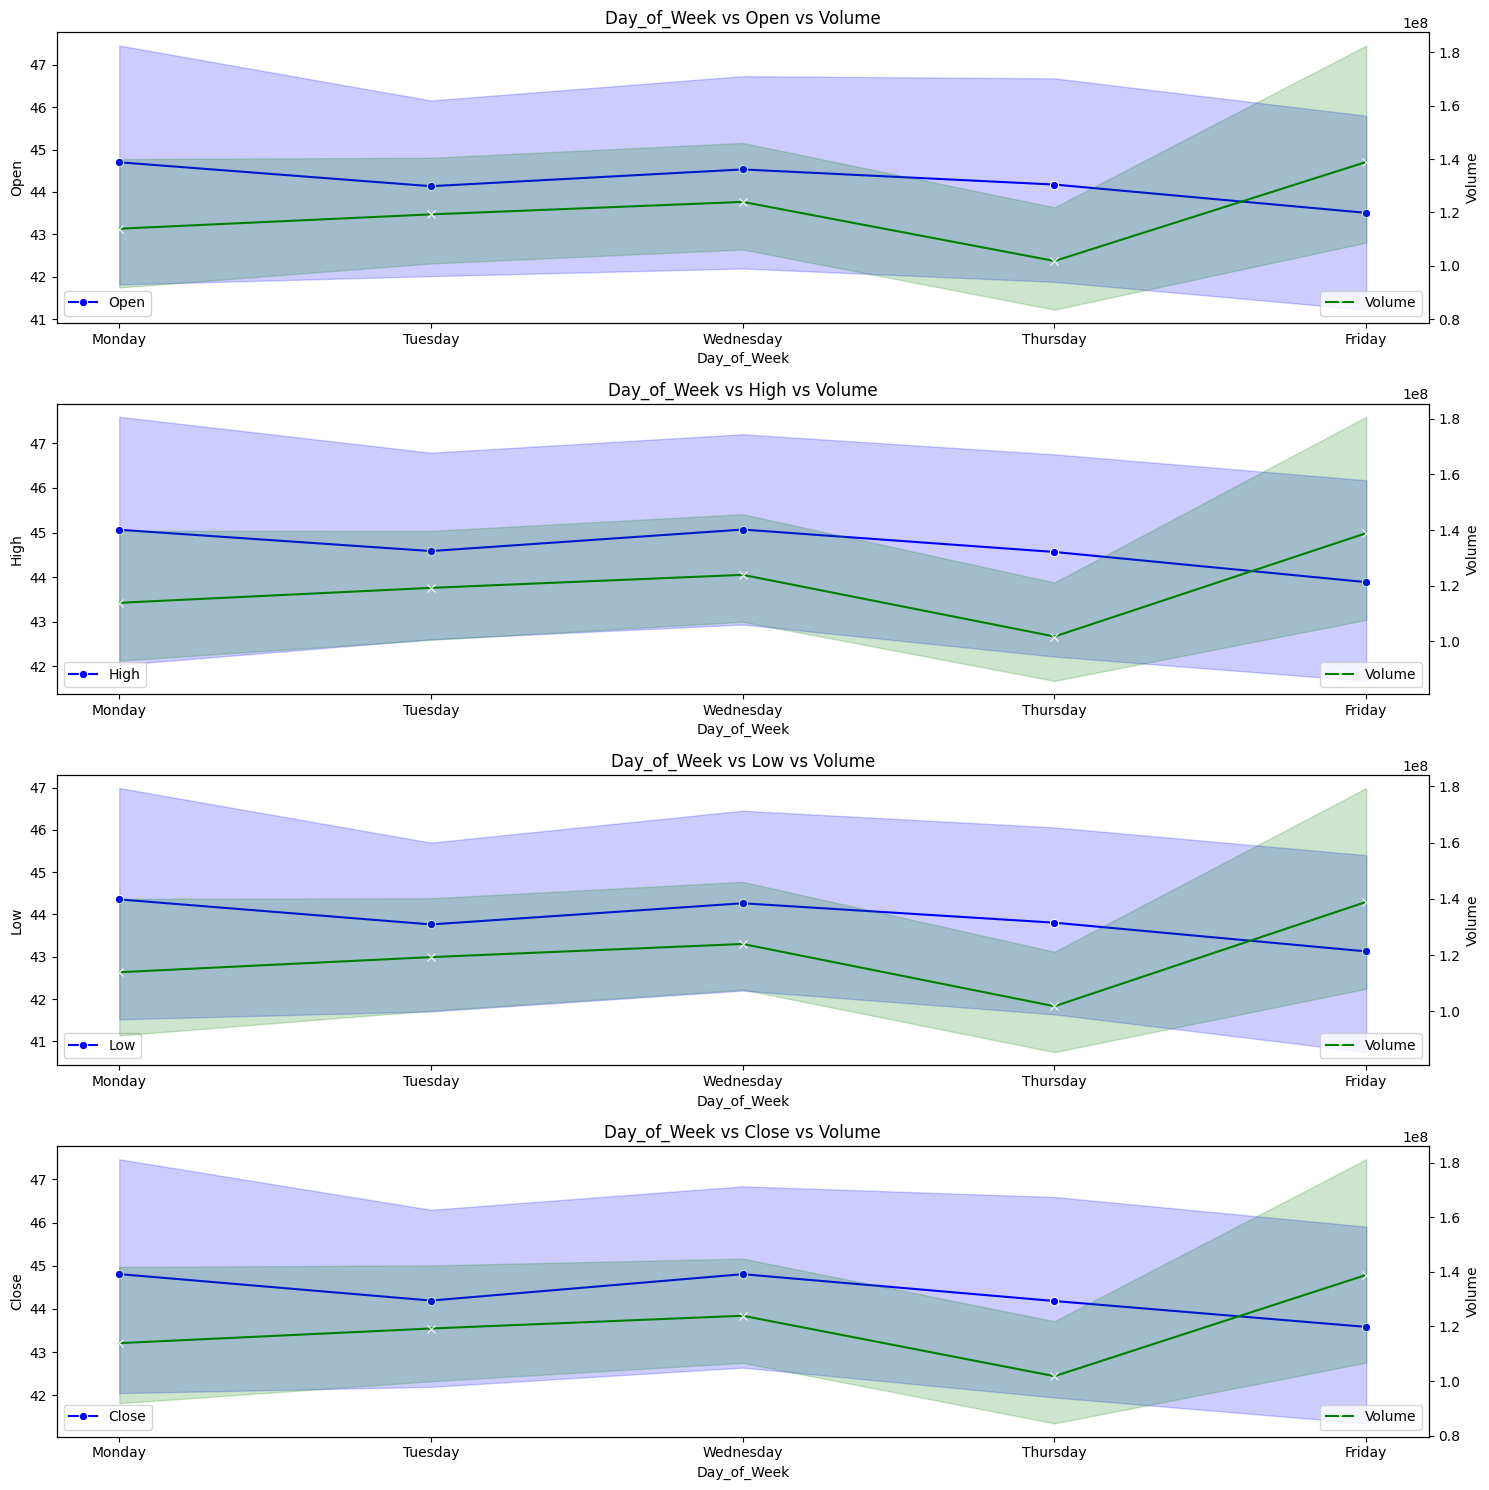

In [27]:
# Find how day of month impacts price
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
fig, axes = plt.subplots(nrows=len(price_cols), ncols = 1, figsize=(15,15))
for i, col in enumerate(price_cols):
  sns.lineplot(data=stock_price_by_day_sorted, x='Day_of_Week', y=col, ax=axes[i], color = 'blue', marker = 'o', label=col)
  axes[i].legend(loc='lower left')
  # Create a second y-axis for the bar chart
  ax2 = axes[i].twinx()
  sns.lineplot(data=stock_price_by_day_sorted, x='Day_of_Week', y='Volume', ax=ax2, marker = 'x', color='green', label='Volume')
  ax2.legend(loc='lower right')
  #sns.barplot(data=stock_price_by_day, x='Date', y='Volume', ax=ax2, marker = 'o')
  axes[i].set_xlabel('Day_of_Week')
  axes[i].set_ylabel(col)
  ax2.set_ylabel('Volume')
  axes[i].set_title(f'Day_of_Week vs {col} vs Volume')
  #plt.grid(True)
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The comparison of day of the week vs price vs Volume clearly suggests that the stock is generally traded more on Friday. We can also see that it is sold more (volume going down) on Thursday. This can cause stock prices to go down on Friday and then going up the next Monday.

Text(0.5, 0, 'Day of Week')

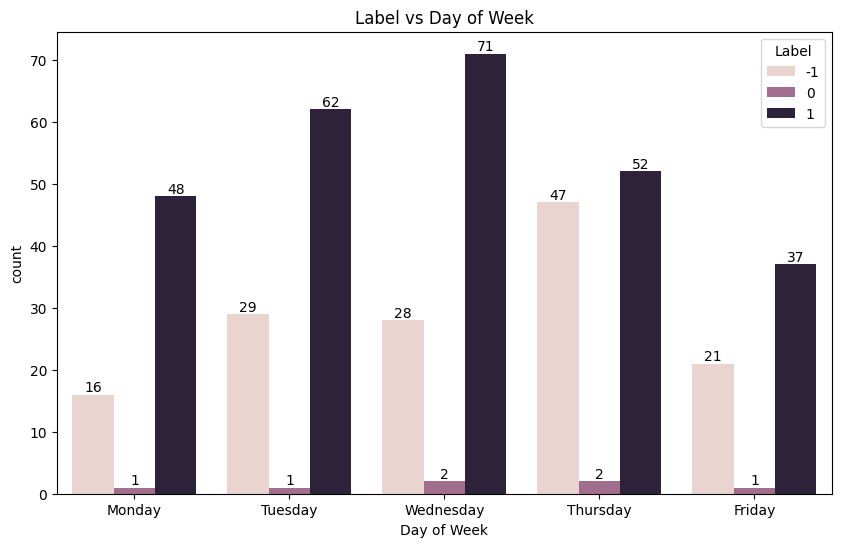

In [28]:
# Label vs Day of week
plt.figure(figsize=(10,6))
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
ax = sns.countplot(data=stock_data_df, x='Day_of_Week', hue='Label', order=custom_order)
#plt.bar_label(ticks=[0,1,2], labels=['Negative', 'Neutral', 'Positive']) # Label the sentiment for better view
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.title('Label vs Day of Week')
plt.xlabel('Day of Week')

**Observations**
* Lot of the positive sentiments are seen on mid week (Wed and Tuesday)
* Lot of negative sentiments are during Thrursdays

## **Data Preprocessing**

In [29]:
X = stock_data_df.copy()
y = stock_data_df['Label']

# Test train split by date
train = X[stock_data_df['Date'] < '2019-04-01'] # 347
test = X[stock_data_df['Date'] >= '2019-04-01'] # 71

X_train = train.copy()
y_train = train['Label']
X_test = test.copy()
y_test = test['Label']

In [30]:
print(y_train.value_counts())
print(y_test.value_counts())

Label
 1    217
-1    124
 0      6
Name: count, dtype: int64
Label
 1    53
-1    17
 0     1
Name: count, dtype: int64


* The data is imbalanced as we saw in EDA. When we do a split by date, one neutral sentiment is in test while there are 6 neutral sentiments in training and 1 in test

In [41]:
# Random Test train split and adding stratify to evenly distribute the labels. Not going by this based on discussion forum
# X = stock_data_df.copy()
# y = stock_data_df['Label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
print(f"Train data shape:{X_train.shape}")
print(f"Test data shape:{X_test.shape}")
print(f"Train label shape:{y_train.shape}")
print(f"Test label shape:{y_test.shape}")

Train data shape:(347, 11)
Test data shape:(71, 11)
Train label shape:(347,)
Test label shape:(71,)


## **Word Embeddings**

#### **Word2Vec**

In [32]:
# Tokenize the words in the news using the simple_process library
X_train['News_token'] = X_train['News'].apply(lambda x: simple_preprocess(x))
X_test['News_token'] = X_test['News'].apply(lambda x: simple_preprocess(x))

In [33]:
X_train.head(5)

,Date,News,Open,High,Low,Close,Volume,Label,Month,Day_of_Week,News_Length,News_token
0,2019-01-02,The dollar minutes ago tumbled to 106 67 from...,38.72,39.71,38.56,39.48,130672400,1,1,Wednesday,161,"[the, dollar, minutes, ago, tumbled, to, from,..."
1,2019-01-02,By Wayne Cole and Swati Pandey SYDNEY Reuters...,38.72,39.71,38.56,39.48,130672400,-1,1,Wednesday,385,"[by, wayne, cole, and, swati, pandey, sydney, ..."
2,2019-01-02,By Stephen Culp NEW YORK Reuters Wall Stre...,38.72,39.71,38.56,39.48,130672400,0,1,Wednesday,636,"[by, stephen, culp, new, york, reuters, wall, ..."
3,2019-01-02,By Wayne Cole SYDNEY Reuters The Australia...,38.72,39.71,38.56,39.48,130672400,-1,1,Wednesday,665,"[by, wayne, cole, sydney, reuters, the, austra..."
4,2019-01-02,Investing com Asian equities fell in morning...,38.72,39.71,38.56,39.48,130672400,1,1,Wednesday,395,"[investing, com, asian, equities, fell, in, mo..."


In [34]:
# Creating word2vec embedding
vector_size = 300
word2vec_model = Word2Vec(sentences=X_train['News_token'], vector_size=vector_size, window=5, min_count=1, workers=6)

In [35]:
print(f"The length of vocabulary is {len(list(word2vec_model.wv.key_to_index))}")

The length of vocabulary is 10361


In [36]:
# Aggregating the words vectors for each review (sentence encoding)
words = list(word2vec_model.wv.key_to_index.keys()) # Getting all the words from the tokens generated earlier

# Creating function that takes a sentence or multiple sentences as argument and it returns vector average of all words in that sentence
def average_vectorizer_Word2Vec(sentence):
  feature_vector = np.zeros((vector_size,), dtype='float64')
  word_in_vocab = [word for word in sentence.split() if word in words]
  for word in word_in_vocab:
      feature_vector = np.add(feature_vector, word2vec_model.wv[word])
  if len(word_in_vocab) > 0:
    feature_vector = np.divide(feature_vector, len(word_in_vocab))
  return feature_vector

In [37]:
# Embedding the news content into multiple feature vectors
X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns = ['Feature '+ str(i) for i in range(vector_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns = ['Feature '+ str(i) for i in range(vector_size)])

In [38]:
print(X_train_wv.shape)
print(X_test_wv.shape)

(347, 300)
(71, 300)


##### Testing/Understanding the embeddings - Can be Ignored

In [39]:
word2vec_model.wv.most_similar('apple')

[('tsla', 0.9982923269271851),
 ('googl', 0.997797966003418),
 ('netflix', 0.996893584728241),
 ('brka', 0.9960697889328003),
 ('ebay', 0.9958891868591309),
 ('nellis', 0.995715320110321),
 ('ratio', 0.9955605864524841),
 ('cat', 0.9942119121551514),
 ('facebook', 0.9931811690330505),
 ('avgo', 0.9929273724555969)]

In [40]:
word2vec_model.wv.most_similar('bear')

[('where', 0.997188150882721),
 ('past', 0.9971650242805481),
 ('powell', 0.997160792350769),
 ('looking', 0.9971596002578735),
 ('reach', 0.9971592426300049),
 ('two', 0.9971444606781006),
 ('positive', 0.997138261795044),
 ('fed', 0.9971379041671753),
 ('meeting', 0.9971340298652649),
 ('rate', 0.9971238374710083)]

In [41]:
word2vec_model.wv['apple']

array([-0.52586085,  0.4675372 ,  0.24383965,  0.27894616, -0.09115109,
       -0.40201417,  0.97282815,  1.0142943 ,  0.1192622 , -0.11897358,
        0.14795767, -0.9253808 , -0.33663884,  0.02744517, -0.3381996 ,
       -0.7801032 ,  0.5118907 , -0.12336071,  0.2574078 , -0.04649182,
        0.31435615, -0.29936054,  0.2762235 , -0.01570907,  0.72348297,
       -0.17715515, -0.4159618 ,  0.32101202, -0.23760656, -0.52498496,
        0.2560471 , -0.36645797,  0.05090678,  0.2069885 , -0.2428818 ,
       -0.357379  ,  0.5662294 , -0.56645393,  0.22475028,  0.21695122,
        0.09988417, -0.01135968,  0.08268144, -0.11892637, -0.13245933,
       -0.07914213,  0.58151096,  0.47042856, -0.06881541,  0.34862494,
        0.14005601, -0.26153204, -0.46154395,  0.18606968, -0.55891734,
        0.5653252 ,  0.08705914,  0.00930059,  0.20948553,  0.06562321,
       -0.30314294, -0.15533775,  0.25378534,  0.10804188, -0.06991453,
        0.5031299 , -0.35308108,  0.42760935, -0.4513288 , -0.68

### **Sentence Transformer**

In [42]:
model_sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [43]:
# Create the copy of the training vector for sentence transformer model
X_train_st = X_train.copy()
X_test_st = X_test.copy()

In [44]:
# Create the embeddings for the News in the data set
X_train_st = model_sentence_transformer.encode(X_train_st['News'].tolist())
X_test_st = model_sentence_transformer.encode(X_test_st['News'].tolist())

In [45]:
print(X_train_st.shape)
print(X_test_st.shape)

(347, 384)
(71, 384)


## **Sentiment Analysis**

### **Model Evaluation Criterion**

**Note:**  
You can use the helper functions provided below to:
- Plot a **confusion matrix** (`plot_confusion_matrix`)
- Generate key **classification metrics** like accuracy, recall, precision, and F1-score (`model_performance_classification_sklearn`)

These are ready-to-use. However, you’re welcome to explore and write your own evaluation code if you prefer. Feel free to modify or extend these as per your learning goals!

##### **Utility Functions**

In [46]:
def plot_confusion_matrix(actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

# The below function will plot multiple confusion matrix together. Sometimes it is good to see the confusion matrix of all models together

def plot_confusion_matrix_multiple(actual, predicted, titles):
  """
  Plot multiple confusion matrices to visualize the performance of multiple classification models.

  Parameters:
  actual (array-like): The true labels.
  predicted (array-like): The predicted labels from the model.
  titles (list): List of titles for each confusion matrix.

  Returns:
  None: Displays the confusion matrix plot.
  """
  # Create a new figure with a specified size
  plt.figure(figsize=(8, 6))
  for i, y_pred in enumerate(predicted):
    # Compute the confusion matrix.
    cm = confusion_matrix(actual, y_pred)
    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((np.array(actual), y_pred)))))
    plt.subplot(int(len(predicted)/2),int(len(predicted)/2),i+1)
    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # Label for the y-axis
    plt.ylabel('Actual')
    # Label for the x-axis
    plt.xlabel('Predicted')
    # Title of the plot
    title = titles[i]
    plt.title(f'{title}')
  plt.tight_layout()
  # Display the plot
  plt.show()

In [47]:
def model_performance_classification_sklearn(actual, predicted):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score). The scores are rounded to 4 decimal places.
    """

    # Compute Accuracy
    acc = round(accuracy_score(actual,predicted),4)
    # Compute Recall
    recall = round(recall_score(actual,predicted,average='weighted'),4)
    # Compute Precision
    precision = round(precision_score(actual,predicted,average='weighted'),4)
    # Compute F1-score
    f1 = round(f1_score(actual,predicted,average='weighted'),4)

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

### **Build Model with Initial Parameters**

### **Build Random Forest Models using different text embeddings**

#### **Random Forest Model using Word2Vec embeddings**

##### Model 1- Random Forest - Word2Vec

In [48]:
# Building the model
rf_wv_transformer_model1 = RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=42)

# Fitting word vec embeddings to Random forest model
rf_wv_transformer_model1.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

###### Model Evaluation

In [51]:
y_train_pred_rf_wv_model1 = rf_wv_transformer_model1.predict(X_train_wv)
y_test_pred_rf_wv_model1 = rf_wv_transformer_model1.predict(X_test_wv)

Confusion Matrix - Training


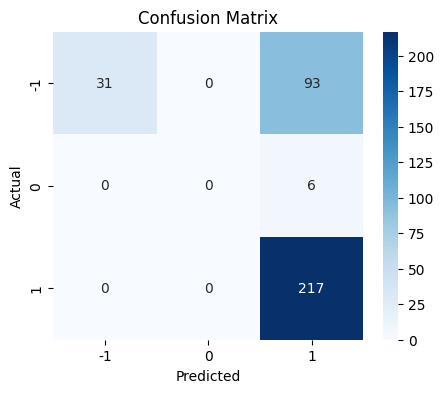

Confusion Matrix - Test


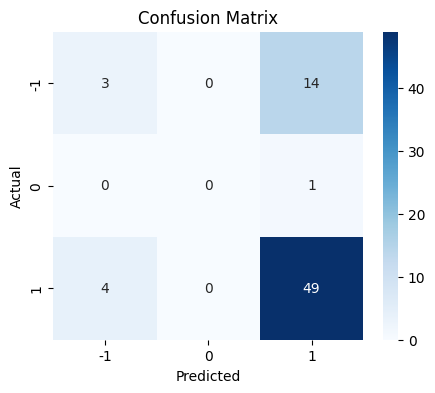

In [52]:
print("Confusion Matrix - Training")
plot_confusion_matrix(y_train, y_train_pred_rf_wv_model1)

print("Confusion Matrix - Test")
plot_confusion_matrix(y_test, y_test_pred_rf_wv_model1)

In [53]:
# Evaluation metrics for the model
eval_train_rf_wv_transformer_model1 = model_performance_classification_sklearn(y_train, y_train_pred_rf_wv_model1)
eval_test_rf_wv_transformer_model1 = model_performance_classification_sklearn(y_test, y_test_pred_rf_wv_model1)
print(eval_train_rf_wv_transformer_model1)
print(eval_test_rf_wv_transformer_model1)

   Accuracy  Recall  Precision      F1
0    0.7147  0.7147     0.7868  0.6521
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6741  0.6851


Model Evalulation Summary:
* Model seems to be relative underperfomring especially when looking at the unseen data.
* f1 score seems to be relatively low.
* Model fails to capture the neutral sentiments possibly due to imbalanced data set

Possibly a more complex model can make better predictions

##### Model 2- Random Forest - Word2Vec

In [54]:
# Tuning the hyperparameters for the random forest - word2vec model
# Changing the n_estimators to 100 and max_depth to 5

# Building the model
rf_wv_transformer_model2 = RandomForestClassifier(n_estimators=100, max_depth = 5, random_state=42)

# Fitting sentence transformer embeddings to Random forest model
rf_wv_transformer_model2.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

###### Model Evaluation

In [55]:
y_train_pred_rf_wv_model2 = rf_wv_transformer_model2.predict(X_train_wv)
y_test_pred_rf_wv_model2 = rf_wv_transformer_model2.predict(X_test_wv)

Confusion Matrix - Training


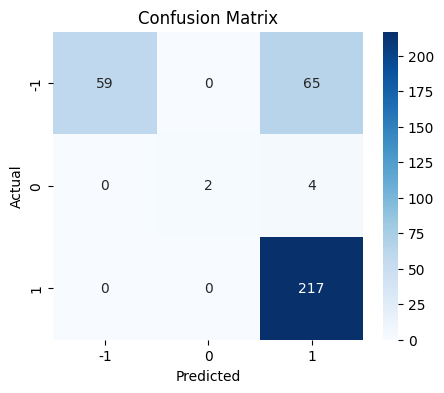

Confusion Matrix - Test


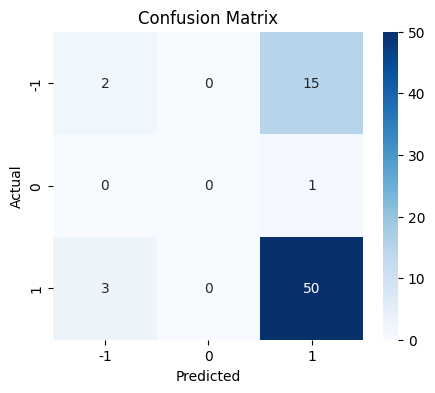

In [56]:
# Plot the confusion matrix
print("Confusion Matrix - Training")
plot_confusion_matrix(y_train, y_train_pred_rf_wv_model2)

print("Confusion Matrix - Test")
plot_confusion_matrix(y_test, y_test_pred_rf_wv_model2)

In [57]:
# Evaluation Metrics for random forest - sentence transformer model
eval_train_rf_wv_transformer_model2 = model_performance_classification_sklearn(y_train, y_train_pred_rf_wv_model2)
eval_test_rf_wv_transformer_model2 = model_performance_classification_sklearn(y_test, y_test_pred_rf_wv_model2)
print('Evaluation - Model 1')
print(eval_train_rf_wv_transformer_model1)
print(eval_test_rf_wv_transformer_model1)

print('\n Evaluation - Model 2')
print(eval_train_rf_wv_transformer_model2)
print(eval_test_rf_wv_transformer_model2)

Evaluation - Model 1
   Accuracy  Recall  Precision      F1
0    0.7147  0.7147     0.7868  0.6521
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6741  0.6851

 Evaluation - Model 2
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8491  0.7786
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6613  0.6708


Model Evalulation Summary:

* Model performance for training is improved but the test data has not shown any improvement
* Model started capturing the neutral sentiments in training, but missing from test possibly due to imbalanced data set
* Looks like model did not learn much after increasing the depth

Tuning it again to see if it learns and improves the prediction

##### Model 3- Random Forest - Word2Vec

In [58]:
# Tuning the hyperparameters for the random forest - word2vec model
# Changing the n_estimators to 200 and max_depth to 5

# Building the model
rf_wv_transformer_model3 = RandomForestClassifier(n_estimators=200, max_depth = 5, random_state=42)

# Fitting sentence transformer embeddings to Random forest model
rf_wv_transformer_model3.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

###### Model Evaluation

In [59]:
y_train_pred_rf_wv_model3 = rf_wv_transformer_model3.predict(X_train_wv)
y_test_pred_rf_wv_model3 = rf_wv_transformer_model3.predict(X_test_wv)

Confusion Matrix - Training


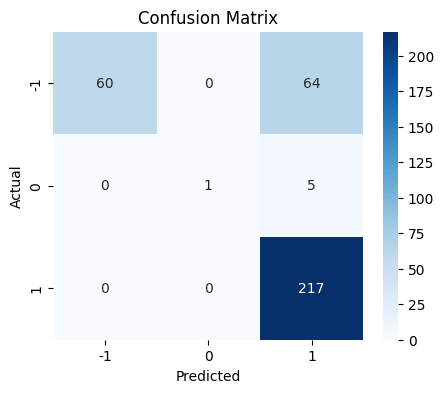

Confusion Matrix - Test


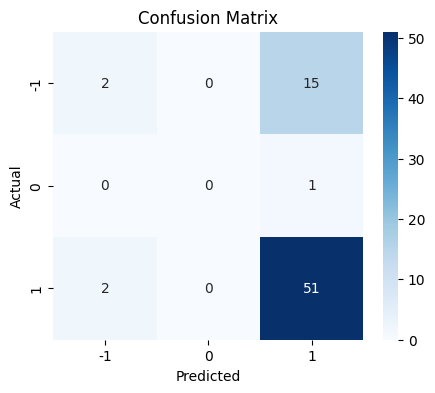

In [60]:
# Plot the confusion matrix
print("Confusion Matrix - Training")
plot_confusion_matrix(y_train, y_train_pred_rf_wv_model3)

print("Confusion Matrix - Test")
plot_confusion_matrix(y_test, y_test_pred_rf_wv_model3)

In [61]:
# Evaluation Metrics for random forest - sentence transformer model
eval_train_rf_wv_transformer_model3 = model_performance_classification_sklearn(y_train, y_train_pred_rf_wv_model3)
eval_test_rf_wv_transformer_model3 = model_performance_classification_sklearn(y_test, y_test_pred_rf_wv_model3)
print('Evaluation - Model 1')
print(eval_train_rf_wv_transformer_model1)
print(eval_test_rf_wv_transformer_model1)

print('\n Evaluation - Model 2')
print(eval_train_rf_wv_transformer_model2)
print(eval_test_rf_wv_transformer_model2)

print('\n Evaluation - Model 3')
print(eval_train_rf_wv_transformer_model3)
print(eval_test_rf_wv_transformer_model3)

Evaluation - Model 1
   Accuracy  Recall  Precision      F1
0    0.7147  0.7147     0.7868  0.6521
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6741  0.6851

 Evaluation - Model 2
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8491  0.7786
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6613  0.6708

 Evaluation - Model 3
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8491  0.7776
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.6879  0.6801


Model Evalulation Summary:

* Model performance seems to be improved slightly for testing data. Not seeing any considerable improvement
* Model started capturing the neutral sentiments in training, but missing from test possibly due to imbalanced data set

Possibly one more hyperparameter tuning to see if it improves the prediction

##### Model 4 - Random Forest - Word2Vec

In [62]:
# Tuning the hyperparameters for the random forest - word2vec model
# Changing the n_estimators to 300 and max_depth to 5

# Building the model
rf_wv_transformer_model4 = RandomForestClassifier(n_estimators=300, max_depth = 5, random_state=42)

# Fitting sentence transformer embeddings to Random forest model
rf_wv_transformer_model4.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=5, n_estimators=300, random_state=42)

###### Model Evaluation

In [63]:
y_train_pred_rf_wv_model4 = rf_wv_transformer_model4.predict(X_train_wv)
y_test_pred_rf_wv_model4 = rf_wv_transformer_model4.predict(X_test_wv)

Confusion Matrix - Training


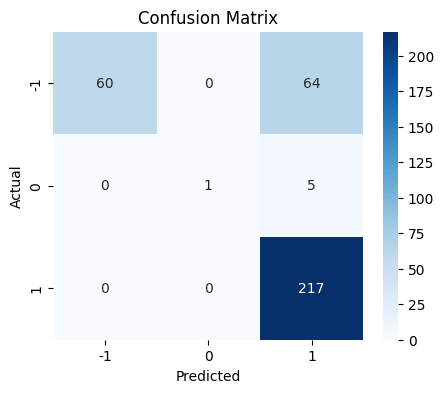

Confusion Matrix - Test


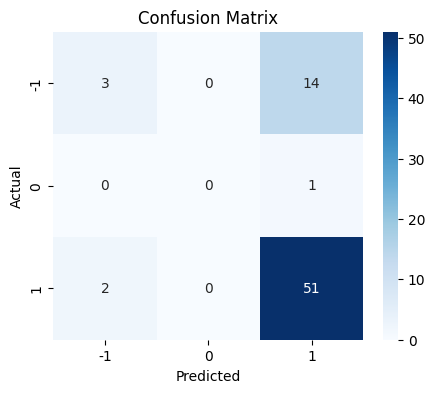

In [64]:
# Plot the confusion matrix
print("Confusion Matrix - Training")
plot_confusion_matrix(y_train, y_train_pred_rf_wv_model4)

print("Confusion Matrix - Test")
plot_confusion_matrix(y_test, y_test_pred_rf_wv_model4)

In [65]:
# Evaluation Metrics for random forest - sentence transformer model
eval_train_rf_wv_transformer_model4 = model_performance_classification_sklearn(y_train, y_train_pred_rf_wv_model4)
eval_test_rf_wv_transformer_model4 = model_performance_classification_sklearn(y_test, y_test_pred_rf_wv_model4)

print('Evaluation - Model 1')
print(eval_train_rf_wv_transformer_model1)
print(eval_test_rf_wv_transformer_model1)

print('\n Evaluation - Model 2')
print(eval_train_rf_wv_transformer_model2)
print(eval_test_rf_wv_transformer_model2)

print('\n Evaluation - Model 3')
print(eval_train_rf_wv_transformer_model3)
print(eval_test_rf_wv_transformer_model3)

print('\n Evaluation - Model 4')
print(eval_train_rf_wv_transformer_model4)
print(eval_test_rf_wv_transformer_model4)

Evaluation - Model 1
   Accuracy  Recall  Precision      F1
0    0.7147  0.7147     0.7868  0.6521
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6741  0.6851

 Evaluation - Model 2
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8491  0.7786
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6613  0.6708

 Evaluation - Model 3
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8491  0.7776
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.6879  0.6801

 Evaluation - Model 4
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8491  0.7776
   Accuracy  Recall  Precision      F1
0    0.7606  0.7606     0.7205  0.7051


Model Evalulation Summary:

* Looks like some slight improvement than the earlier models
* The recall and f1 score seems to have improved

##### All Random Forest Word2Vec model comparisons

In [260]:
# All Random Forest Word2Vec evaluations put together
eval_train_rf_wv_transformer_model1['Model'] = 'Model_1_Random Forest Word2Vec'
eval_train_rf_wv_transformer_model2['Model'] = 'Model_2_Random Forest Word2Vec'
eval_train_rf_wv_transformer_model3['Model'] = 'Model_3_Random Forest Word2Vec'
eval_train_rf_wv_transformer_model4['Model'] = 'Model_4_Random Forest Word2Vec'

eval_test_rf_wv_transformer_model1['Model'] = 'Model_1_Random Forest Word2Vec'
eval_test_rf_wv_transformer_model2['Model'] = 'Model_2_Random Forest Word2Vec'
eval_test_rf_wv_transformer_model3['Model'] = 'Model_3_Random Forest Word2Vec'
eval_test_rf_wv_transformer_model4['Model'] = 'Model_4_Random Forest Word2Vec'

eval_train_rf_wv_transformer_model1['Type'] = 'Train'
eval_train_rf_wv_transformer_model2['Type'] = 'Train'
eval_train_rf_wv_transformer_model3['Type'] = 'Train'
eval_train_rf_wv_transformer_model4['Type'] = 'Train'

eval_test_rf_wv_transformer_model1['Type'] = 'Test'
eval_test_rf_wv_transformer_model2['Type'] = 'Test'
eval_test_rf_wv_transformer_model3['Type'] = 'Test'
eval_test_rf_wv_transformer_model4['Type'] = 'Test'

eval_train_rf_wv_transformer_model1['Hyperparameters'] = [{'n_estimators':100, 'max_depth':3}]
eval_train_rf_wv_transformer_model2['Hyperparameters'] = [{'n_estimators':100, 'max_depth':5}]
eval_train_rf_wv_transformer_model3['Hyperparameters'] = [{'n_estimators':200, 'max_depth':5}]
eval_train_rf_wv_transformer_model4['Hyperparameters'] = [{'n_estimators':300, 'max_depth':5}]

eval_test_rf_wv_transformer_model1['Hyperparameters'] = [{'n_estimators':100, 'max_depth':3}]
eval_test_rf_wv_transformer_model2['Hyperparameters'] = [{'n_estimators':100, 'max_depth':5}]
eval_test_rf_wv_transformer_model3['Hyperparameters'] = [{'n_estimators':200, 'max_depth':5}]
eval_test_rf_wv_transformer_model4['Hyperparameters'] = [{'n_estimators':300, 'max_depth':5}]

In [261]:
eval_rf_wv_transformer = pd.concat([eval_train_rf_wv_transformer_model1, eval_train_rf_wv_transformer_model2, eval_train_rf_wv_transformer_model3, eval_train_rf_wv_transformer_model4, eval_test_rf_wv_transformer_model1, eval_test_rf_wv_transformer_model2, eval_test_rf_wv_transformer_model3, eval_test_rf_wv_transformer_model4])
eval_rf_wv_transformer[['Model', 'Type', 'Hyperparameters', 'Accuracy',	'Recall',	'Precision',	'F1']].sort_values(by=['Model', 'Type'])

,Model,Type,Hyperparameters,Accuracy,Recall,Precision,F1
0,Model_1_Random Forest Word2Vec,Test,"{'n_estimators': 100, 'max_depth': 3}",0.7324,0.7324,0.6741,0.6851
0,Model_1_Random Forest Word2Vec,Train,"{'n_estimators': 100, 'max_depth': 3}",0.7147,0.7147,0.7868,0.6521
0,Model_2_Random Forest Word2Vec,Test,"{'n_estimators': 100, 'max_depth': 5}",0.7324,0.7324,0.6613,0.6708
0,Model_2_Random Forest Word2Vec,Train,"{'n_estimators': 100, 'max_depth': 5}",0.8012,0.8012,0.8491,0.7786
0,Model_3_Random Forest Word2Vec,Test,"{'n_estimators': 200, 'max_depth': 5}",0.7465,0.7465,0.6879,0.6801
0,Model_3_Random Forest Word2Vec,Train,"{'n_estimators': 200, 'max_depth': 5}",0.8012,0.8012,0.8491,0.7776
0,Model_4_Random Forest Word2Vec,Test,"{'n_estimators': 300, 'max_depth': 5}",0.7606,0.7606,0.7205,0.7051
0,Model_4_Random Forest Word2Vec,Train,"{'n_estimators': 300, 'max_depth': 5}",0.8012,0.8012,0.8491,0.7776


**Final Model Selection**
* Based on the model evaluations it looks like Model 2 and Model 3 performs relatively well on both training and testing dataset
* Model 1 did not perform well in training
* Model 4 probably is the best in this case to go with as it performs better with unseen data. The predictions with training and testing seems to be in similar range

#### **Random Forest Model using Sentence Transformer embeddings**

##### Model 1- Random Forest - Sentence Transformer

In [68]:
# Building the model - max_depth =3 and n_estimators = 100
rf_st_transformer_model1 = RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=42)

# Fitting sentence transformer embeddings to Random forest model
rf_st_transformer_model1.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

###### Model Evaluation

In [70]:
y_train_pred_rf_st_model1 = rf_st_transformer_model1.predict(X_train_st)
y_test_pred_rf_st_model1 = rf_st_transformer_model1.predict(X_test_st)

Confusion Matrix - Training


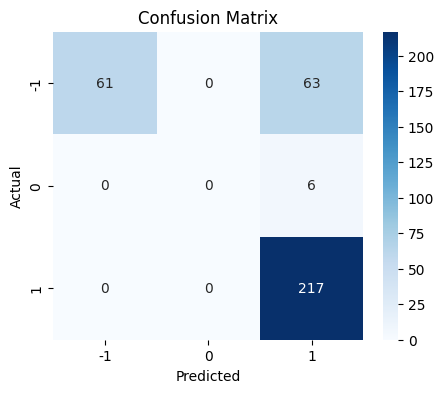

Confusion Matrix - Test


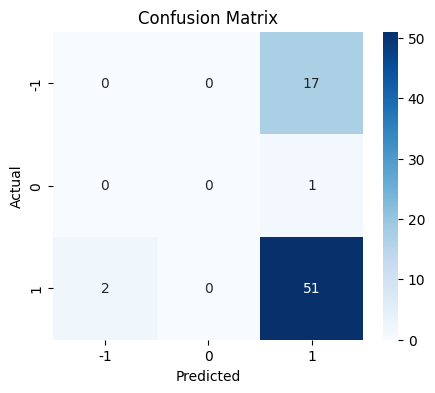

In [71]:
# Plot the confusion matrix
print("Confusion Matrix - Training")
plot_confusion_matrix(y_train, y_train_pred_rf_st_model1)

print("Confusion Matrix - Test")
plot_confusion_matrix(y_test, y_test_pred_rf_st_model1)

In [72]:
# Evaluation Metrics for random forest - sentence transformer model
eval_train_rf_st_transformer_model1 = model_performance_classification_sklearn(y_train, y_train_pred_rf_st_model1)
eval_test_rf_st_transformer_model1 = model_performance_classification_sklearn(y_test, y_test_pred_rf_st_model1)
print(eval_train_rf_st_transformer_model1)
print(eval_test_rf_st_transformer_model1)

   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8318  0.7752
   Accuracy  Recall  Precision      F1
0    0.7183  0.7183     0.5517  0.6241


Model Evalulation Summary:
* Model seems to be relative underperfomring on unseen data even though the performance on training data is better than the random forest word2vec model for same hyperparameters.
* f1 score seems to be relatively low for unseen data.
* Model fails to capture the neutral sentiments possibly due to imbalanced data set

Possibly tuning the parameters might help with better predictions

##### Model 2- Random Forest - Sentence Transformer

In [77]:
# Tuning the hyperparameters for the random forest - word2vec model
# Changing the max_depth to 5

# Building the model
rf_st_transformer_model2 = RandomForestClassifier(n_estimators=100, max_depth = 5, random_state=42)

# Fitting sentence transformer embeddings to Random forest model
rf_st_transformer_model2.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

###### Model Evaluation

In [78]:
y_train_pred_rf_st_model2 = rf_st_transformer_model2.predict(X_train_st)
y_test_pred_rf_st_model2 = rf_st_transformer_model2.predict(X_test_st)

Confusion Matrix - Training


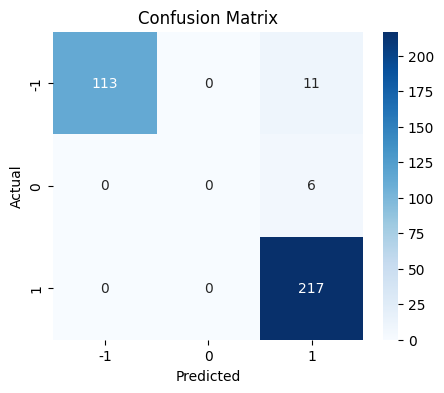

Confusion Matrix - Test


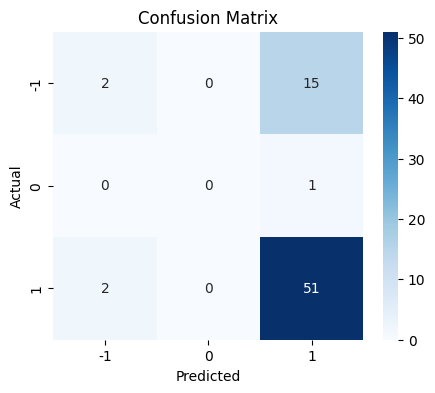

In [79]:
# Plot the confusion matrix
print("Confusion Matrix - Training")
plot_confusion_matrix(y_train, y_train_pred_rf_st_model2)

print("Confusion Matrix - Test")
plot_confusion_matrix(y_test, y_test_pred_rf_st_model2)

In [81]:
# Evaluation Metrics for random forest - sentence transformer model
eval_train_rf_st_transformer_model2 = model_performance_classification_sklearn(y_train, y_train_pred_rf_st_model2)
eval_test_rf_st_transformer_model2 = model_performance_classification_sklearn(y_test, y_test_pred_rf_st_model2)
print('Evaluation - Model 1')
print(eval_train_rf_st_transformer_model1)
print(eval_test_rf_st_transformer_model1)

print('\n Evaluation - Model 2')
print(eval_train_rf_st_transformer_model2)
print(eval_test_rf_st_transformer_model2)

Evaluation - Model 1
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8318  0.7752
   Accuracy  Recall  Precision      F1
0    0.7183  0.7183     0.5517  0.6241

 Evaluation - Model 2
   Accuracy  Recall  Precision      F1
0     0.951   0.951     0.9373  0.9426
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.6879  0.6801


Model Evalulation Summary:
* Model seems to perform well on train data, but not that good with test data
* There seems to be an improvement in metrics. f1 score and precision seems to be still relatively low for unseen data.
* Model fails to capture the neutral sentiments possibly due to imbalanced data set

Possibly tuning the parameters might help with better predictions

##### Model 3- Random Forest - Sentence Transformer

In [82]:
# Tuning the hyperparameters for the random forest - word2vec model
# Changing the max_depth to 6 and n_estimators to 200

# Building the model
rf_st_transformer_model3 = RandomForestClassifier(n_estimators=200, max_depth = 6, random_state=42)

# Fitting sentence transformer embeddings to Random forest model
rf_st_transformer_model3.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

###### Model Evaluation

In [83]:
y_train_pred_rf_st_model3 = rf_st_transformer_model3.predict(X_train_st)
y_test_pred_rf_st_model3 = rf_st_transformer_model3.predict(X_test_st)

Confusion Matrix - Training


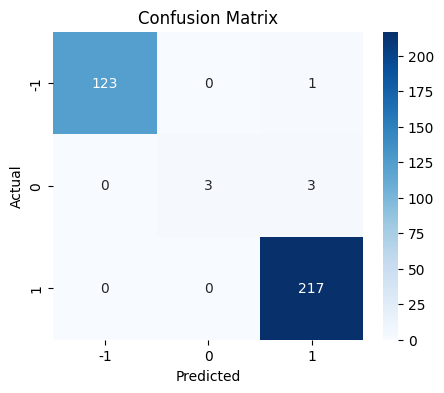

Confusion Matrix - Test


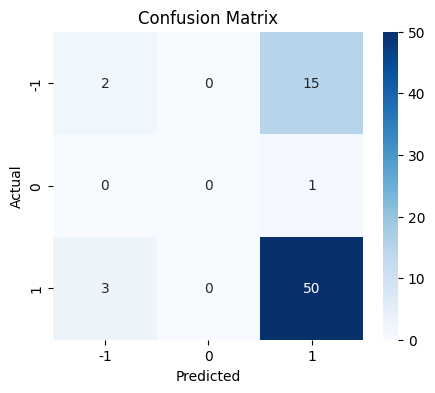

In [84]:
# Plot the confusion matrix
print("Confusion Matrix - Training")
plot_confusion_matrix(y_train, y_train_pred_rf_st_model3)

print("Confusion Matrix - Test")
plot_confusion_matrix(y_test, y_test_pred_rf_st_model3)

In [85]:
# Evaluation Metrics for random forest - sentence transformer model
eval_train_rf_st_transformer_model3 = model_performance_classification_sklearn(y_train, y_train_pred_rf_st_model3)
eval_test_rf_st_transformer_model3 = model_performance_classification_sklearn(y_test, y_test_pred_rf_st_model3)

print('Evaluation - Model 1')
print(eval_train_rf_st_transformer_model1)
print(eval_test_rf_st_transformer_model1)

print('\n Evaluation - Model 2')
print(eval_train_rf_st_transformer_model2)
print(eval_test_rf_st_transformer_model2)

print('\n Evaluation - Model 3')
print(eval_train_rf_st_transformer_model3)
print(eval_test_rf_st_transformer_model3)

Evaluation - Model 1
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8318  0.7752
   Accuracy  Recall  Precision      F1
0    0.7183  0.7183     0.5517  0.6241

 Evaluation - Model 2
   Accuracy  Recall  Precision      F1
0     0.951   0.951     0.9373  0.9426
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.6879  0.6801

 Evaluation - Model 3
   Accuracy  Recall  Precision      F1
0    0.9885  0.9885     0.9887  0.9871
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6613  0.6708


Model Evalulation Summary:
* The training prediction improved, but not much improvement in test prediction

Trying by increasing the depth to 7

##### Model 4- Random Forest - Sentence Transformer

In [86]:
# Tuning the hyperparameters for the random forest - word2vec model
# Changing the max_depth to 7 and n_estimators to 100

# Building the model
rf_st_transformer_model4 = RandomForestClassifier(n_estimators=100, max_depth = 7, random_state=42)

# Fitting sentence transformer embeddings to Random forest model
rf_st_transformer_model4.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=7, random_state=42)

In [87]:
y_train_pred_rf_st_model4 = rf_st_transformer_model4.predict(X_train_st)
y_test_pred_rf_st_model4 = rf_st_transformer_model4.predict(X_test_st)

Confusion Matrix - Training


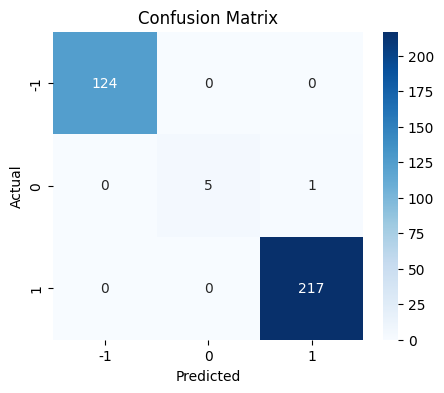

Confusion Matrix - Test


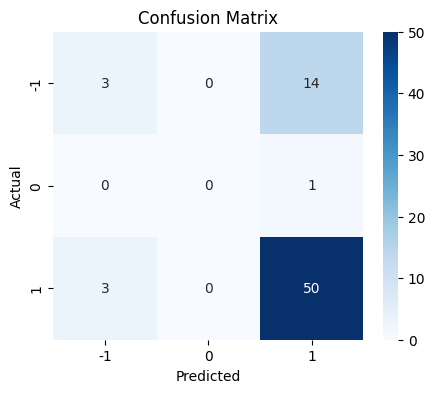

In [88]:
# Plot the confusion matrix
print("Confusion Matrix - Training")
plot_confusion_matrix(y_train, y_train_pred_rf_st_model4)

print("Confusion Matrix - Test")
plot_confusion_matrix(y_test, y_test_pred_rf_st_model4)

In [90]:
# Evaluation Metrics for random forest - sentence transformer model
eval_train_rf_st_transformer_model4 = model_performance_classification_sklearn(y_train, y_train_pred_rf_st_model4)
eval_test_rf_st_transformer_model4 = model_performance_classification_sklearn(y_test, y_test_pred_rf_st_model4)

print('Evaluation - Model 1')
print(eval_train_rf_st_transformer_model1)
print(eval_test_rf_st_transformer_model1)

print('\n Evaluation - Model 2')
print(eval_train_rf_st_transformer_model2)
print(eval_test_rf_st_transformer_model2)

print('\n Evaluation - Model 3')
print(eval_train_rf_st_transformer_model3)
print(eval_test_rf_st_transformer_model3)

print('\n Evaluation - Model 4')
print(eval_train_rf_st_transformer_model4)
print(eval_test_rf_st_transformer_model4)

Evaluation - Model 1
   Accuracy  Recall  Precision      F1
0    0.8012  0.8012     0.8318  0.7752
   Accuracy  Recall  Precision      F1
0    0.7183  0.7183     0.5517  0.6241

 Evaluation - Model 2
   Accuracy  Recall  Precision      F1
0     0.951   0.951     0.9373  0.9426
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.6879  0.6801

 Evaluation - Model 3
   Accuracy  Recall  Precision      F1
0    0.9885  0.9885     0.9887  0.9871
   Accuracy  Recall  Precision      F1
0    0.7324  0.7324     0.6613  0.6708

 Evaluation - Model 4
   Accuracy  Recall  Precision     F1
0    0.9971  0.9971     0.9971  0.997
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.6939  0.6951


Model Evalulation Summary:
* The training prediction is very high
* The test data predictions are better, but not very high
* This model seems to memorize the data, but not really performing weel with unseen data

##### All Random Forest Sentence Transformer model comparisons

In [262]:
# All Random Forest Sentence Transformer evaluations put together
eval_train_rf_st_transformer_model1['Model'] = 'Model_1_Random Forest Sentence Transformer'
eval_train_rf_st_transformer_model2['Model'] = 'Model_2_Random Forest Sentence Transformer'
eval_train_rf_st_transformer_model3['Model'] = 'Model_3_Random Forest Sentence Transformer'
eval_train_rf_st_transformer_model4['Model'] = 'Model_4_Random Forest Sentence Transformer'

eval_test_rf_st_transformer_model1['Model'] = 'Model_1_Random Forest Sentence Transformer'
eval_test_rf_st_transformer_model2['Model'] = 'Model_2_Random Forest Sentence Transformer'
eval_test_rf_st_transformer_model3['Model'] = 'Model_3_Random Forest Sentence Transformer'
eval_test_rf_st_transformer_model4['Model'] = 'Model_4_Random Forest Sentence Transformer'

eval_train_rf_st_transformer_model1['Type'] = 'Train'
eval_train_rf_st_transformer_model2['Type'] = 'Train'
eval_train_rf_st_transformer_model3['Type'] = 'Train'
eval_train_rf_st_transformer_model4['Type'] = 'Train'

eval_test_rf_st_transformer_model1['Type'] = 'Test'
eval_test_rf_st_transformer_model2['Type'] = 'Test'
eval_test_rf_st_transformer_model3['Type'] = 'Test'
eval_test_rf_st_transformer_model4['Type'] = 'Test'

eval_train_rf_st_transformer_model1['Hyperparameters'] = [{'n_estimators':100, 'max_depth':3}]
eval_train_rf_st_transformer_model2['Hyperparameters'] = [{'n_estimators':100, 'max_depth':5}]
eval_train_rf_st_transformer_model3['Hyperparameters'] = [{'n_estimators':200, 'max_depth':6}]
eval_train_rf_st_transformer_model4['Hyperparameters'] = [{'n_estimators':100, 'max_depth':7}]

eval_test_rf_st_transformer_model1['Hyperparameters'] = [{'n_estimators':100, 'max_depth':3}]
eval_test_rf_st_transformer_model2['Hyperparameters'] = [{'n_estimators':100, 'max_depth':5}]
eval_test_rf_st_transformer_model3['Hyperparameters'] = [{'n_estimators':200, 'max_depth':6}]
eval_test_rf_st_transformer_model4['Hyperparameters'] = [{'n_estimators':100, 'max_depth':7}]

In [263]:
eval_rf_st_transformer = pd.concat([eval_train_rf_st_transformer_model1, eval_train_rf_st_transformer_model2, eval_train_rf_st_transformer_model3, eval_train_rf_st_transformer_model4, eval_test_rf_st_transformer_model1, eval_test_rf_st_transformer_model2, eval_test_rf_st_transformer_model3, eval_test_rf_st_transformer_model4])
eval_rf_st_transformer[['Model', 'Type', 'Hyperparameters', 'Accuracy',	'Recall',	'Precision',	'F1']].sort_values(by=['Model', 'Type'])

,Model,Type,Hyperparameters,Accuracy,Recall,Precision,F1
0,Model_1_Random Forest Sentence Transformer,Test,"{'n_estimators': 100, 'max_depth': 3}",0.7183,0.7183,0.5517,0.6241
0,Model_1_Random Forest Sentence Transformer,Train,"{'n_estimators': 100, 'max_depth': 3}",0.8012,0.8012,0.8318,0.7752
0,Model_2_Random Forest Sentence Transformer,Test,"{'n_estimators': 100, 'max_depth': 5}",0.7465,0.7465,0.6879,0.6801
0,Model_2_Random Forest Sentence Transformer,Train,"{'n_estimators': 100, 'max_depth': 5}",0.9510,0.9510,0.9373,0.9426
0,Model_3_Random Forest Sentence Transformer,Test,"{'n_estimators': 200, 'max_depth': 6}",0.7324,0.7324,0.6613,0.6708
0,Model_3_Random Forest Sentence Transformer,Train,"{'n_estimators': 200, 'max_depth': 6}",0.9885,0.9885,0.9887,0.9871
0,Model_4_Random Forest Sentence Transformer,Test,"{'n_estimators': 100, 'max_depth': 7}",0.7465,0.7465,0.6939,0.6951
0,Model_4_Random Forest Sentence Transformer,Train,"{'n_estimators': 100, 'max_depth': 7}",0.9971,0.9971,0.9971,0.9970


**Final Model Selection**

* Based on the model evaluations it looks like Model 2 performs relatively well on both training and testing dataset
* The model to pick using Random Forest on sentence transformer will be Model 2 since it does not seem to memorize the training data. Also, it is less complex and giving the same recall as compared to Model 4

### **Building Neural Network Models using different text embeddings**

#### **Neural Network on Word2Vec embeddings**

#####Data Preprocessing for Neural Network Model

In [93]:
# Create copies and remap labels for fitting the output variable to a neural network
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()

label_map = {-1: 0, 0: 1, 1: 2} # 0: Negative, 1: Neural, 2: Positive
y_train_nn = y_train_nn.replace(label_map) # Categorizing negative sentiment as 2 in place of -1 improves compatibility with common activation and loss functions
y_test_nn = y_test_nn.replace(label_map) # Categorizing negative sentiment as 2 in place of -1 improves compatibility with common activation and loss functions

# One-hot encode the labels
# One-hot encoded targets are directly compatible with the softmax activation function for multi-class classification.
y_train_nn_ohe = tf.keras.utils.to_categorical(y_train_nn, num_classes=3)
y_test_nn_ohe = tf.keras.utils.to_categorical(y_test_nn, num_classes=3)
# print(y_test_nn_ohe)

In [94]:
print(y_train_nn_ohe) # Checking the one hot encoded y label
print(y_train_nn_ohe.shape)
print(y_test_nn_ohe.shape)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
(347, 3)
(71, 3)


##### Model 1 - Neural Network - Word2Vec

In [178]:
import gc

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_wv_model1 = Sequential()
nn_wv_model1.add(Input(shape=(X_train_wv.shape[1],)))
nn_wv_model1.add(Dense(128, activation='tanh'))
nn_wv_model1.add(Dropout(0.2))
nn_wv_model1.add(Dense(64, activation='tanh'))
nn_wv_model1.add(Dropout(0.2))
nn_wv_model1.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
# categorical_crossentropy loss function is a good option for multi class classification problems like the one we have for sentiment analysis
nn_wv_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall'])

# Summary
nn_wv_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,979 (183.51 KB)

 Trainable params: 46,979 (183.51 KB)

 Non-trainable params: 0 (0.00 B)

In [179]:
# Training the model with 25 epochs and a batch_size of 32
import time
start_time = time.time()
history = nn_wv_model1.fit(X_train_wv, y_train_nn_ohe, epochs=25, batch_size=32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9122 - recall: 0.4200
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7418 - recall: 0.5909 
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7256 - recall: 0.5880 
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7248 - recall: 0.6005 
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7314 - recall: 0.5706 
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7212 - recall: 0.6078 
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7499 - recall: 0.5941 
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7401 - recall: 0.5802 
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7120 - recall: 0.5931 
Epoch 10/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7533 - recall: 0.5931 
Epoch 11/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7542 - recall: 0.5821 
Epoch 12/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7302 - recall: 0.6024 
Ep

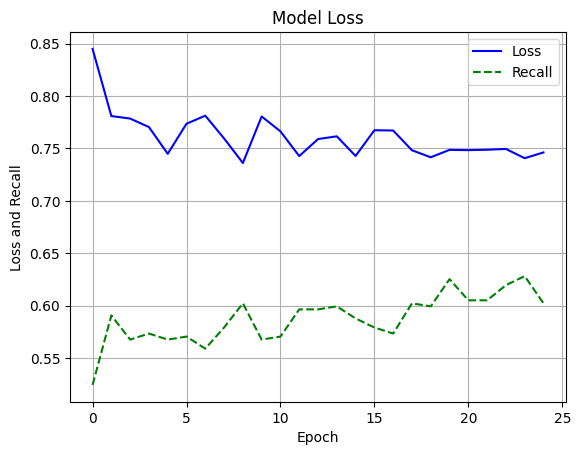

In [180]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history.history['loss'], color='blue', linestyle='-')
plt.plot(history.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'Recall'])
plt.ylabel('Loss and Recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [181]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_wv_prob_model1 = nn_wv_model1.predict(X_train_wv)
y_train_pred_nn_wv_model1 = (y_train_pred_nn_wv_prob_model1 > 0.5).astype(int)
y_train_pred_nn_wv_argmax_model1 = np.argmax(y_train_pred_nn_wv_model1, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_wv_prob_model1 = nn_wv_model1.predict(X_test_wv)
y_test_pred_nn_wv_model1 = (y_test_pred_nn_wv_prob_model1 > 0.5).astype(int)
y_test_pred_nn_wv_argmax_model1 = np.argmax(y_test_pred_nn_wv_model1, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [182]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_wv_argmax_model1) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_wv_argmax_model1) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_wv_argmax_model1[y_train_pred_nn_wv_argmax_model1 == old_val] = new_val
    y_test_pred_nn_wv_argmax_model1[y_test_pred_nn_wv_argmax_model1 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_wv_argmax_model1)
print(y_test_pred_nn_wv_argmax_model1)

Predictions before remapping the labels
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Predictions after remapping the labels
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Confusion Matric Train


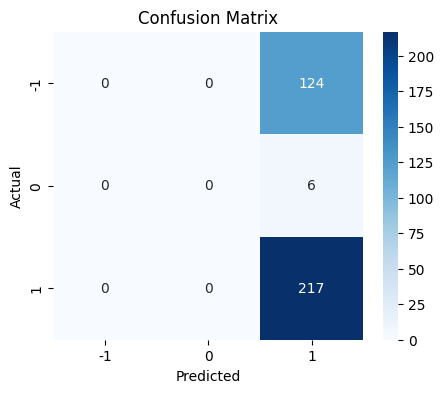

Confusion Matric Test


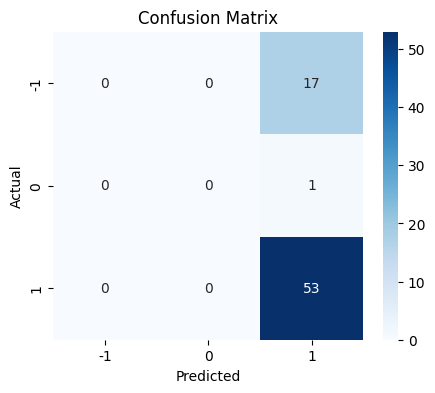

In [183]:
# Confusion Matrix
print('Confusion Matric Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_wv_argmax_model1)

print('Confusion Matric Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_wv_argmax_model1)

In [184]:
# Evaluation metrics for the model
eval_train_nn_wv_transformer_model1 = model_performance_classification_sklearn(y_train, y_train_pred_nn_wv_argmax_model1)
eval_test_nn_wv_transformer_model1 = model_performance_classification_sklearn(y_test, y_test_pred_nn_wv_argmax_model1)
print(eval_train_nn_wv_transformer_model1)
print(eval_test_nn_wv_transformer_model1)

   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381


Model Evalulation Summary:
* Model seems to be underperfomring for training and testing data.
* Possibly a more complex model can make better predictions

##### Model 2 - Neural Network - Word2Vec

In [185]:
# Adding an additional dense layer - 256 Neurons in first, 128 in second and 64 in third
import gc

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_wv_model2 = Sequential()
nn_wv_model2.add(Input(shape=(X_train_wv.shape[1],)))
nn_wv_model2.add(Dense(256, activation='tanh'))
nn_wv_model2.add(Dropout(0.2))
nn_wv_model2.add(Dense(128, activation='tanh'))
nn_wv_model2.add(Dropout(0.2))
nn_wv_model2.add(Dense(64, activation='tanh'))
nn_wv_model2.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
# categorical_crossentropy loss function is a good option for multi class classification problems like the one we have for sentiment analysis
nn_wv_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall'])

# Summary
nn_wv_model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,403 (462.51 KB)

 Trainable params: 118,403 (462.51 KB)

 Non-trainable params: 0 (0.00 B)

In [186]:
# Training the model with 10 epochs (reducing the number or epochs) and a batch_size of 32
import time
start_time = time.time()
history = nn_wv_model2.fit(X_train_wv, y_train_nn_ohe, epochs=10, batch_size=32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9032 - recall: 0.4620
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7633 - recall: 0.5312
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7221 - recall: 0.5703
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7074 - recall: 0.6147
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7180 - recall: 0.6219
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7186 - recall: 0.6137
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7163 - recall: 0.6210
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7109 - recall: 0.6175 
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7038 - recall: 0.6217 
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7096 - recall: 0.6132 
Training time: 4.342753171920776 seconds


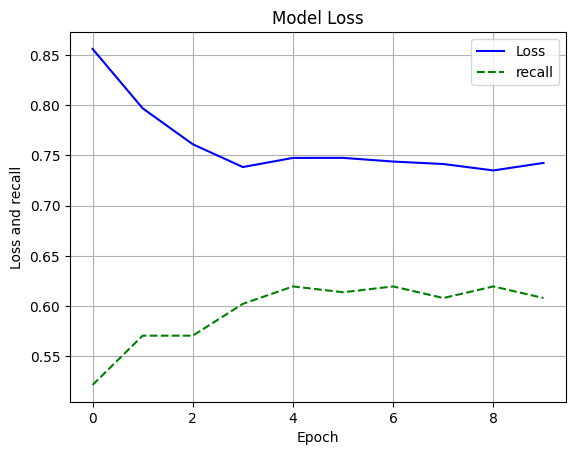

In [187]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history.history['loss'], color='blue', linestyle='-')
plt.plot(history.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'recall'])
plt.ylabel('Loss and recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [188]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_wv_prob_model2 = nn_wv_model2.predict(X_train_wv)
y_train_pred_nn_wv_model2 = (y_train_pred_nn_wv_prob_model2 > 0.5).astype(int)
y_train_pred_nn_wv_argmax_model2 = np.argmax(y_train_pred_nn_wv_model2, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_wv_prob_model2 = nn_wv_model2.predict(X_test_wv)
y_test_pred_nn_wv_model2 = (y_test_pred_nn_wv_prob_model2 > 0.5).astype(int)
y_test_pred_nn_wv_argmax_model2 = np.argmax(y_test_pred_nn_wv_model2, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [189]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_wv_argmax_model2) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_wv_argmax_model2) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_wv_argmax_model2[y_train_pred_nn_wv_argmax_model2 == old_val] = new_val
    y_test_pred_nn_wv_argmax_model2[y_test_pred_nn_wv_argmax_model2 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_wv_argmax_model2)
print(y_test_pred_nn_wv_argmax_model2)

Predictions before remapping the labels
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Predictions after remapping the labels
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Confusion Matric Train


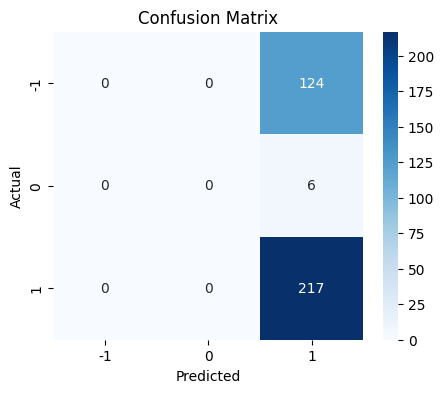

Confusion Matric Test


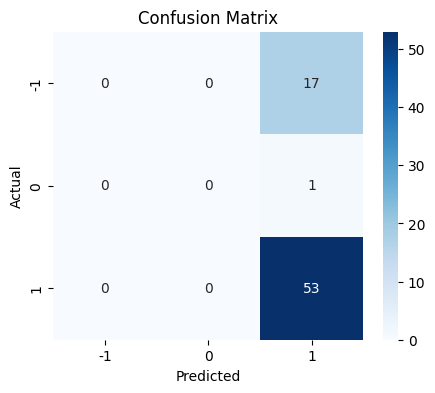

In [190]:
# Confusion Matrix
print('Confusion Matric Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_wv_argmax_model2)

print('Confusion Matric Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_wv_argmax_model2)

In [191]:
# Evaluation metrics for the model
eval_train_nn_wv_transformer_model2 = model_performance_classification_sklearn(y_train, y_train_pred_nn_wv_argmax_model2)
eval_test_nn_wv_transformer_model2 = model_performance_classification_sklearn(y_test, y_test_pred_nn_wv_argmax_model2)
print('Model 1 Evaluation')
print(eval_train_nn_wv_transformer_model1)
print(eval_test_nn_wv_transformer_model1)

print('\n Model 2 Evaluation')
print(eval_train_nn_wv_transformer_model2)
print(eval_test_nn_wv_transformer_model2)

Model 1 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381

 Model 2 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381


Model Evalulation Summary:
* Model does not seem to improve by increasing the number of neurons
* There is a flattened loss curve after the first few epochs. Looks like the model is not learning after that.
* Try to reduce the complexity, reduce the learning rate and run another model

##### Model 3 - Neural Network - Word2Vec

In [199]:
# Reduced the number of layers to 1 with 64 neurons
# set low learning rate for Adam optimizer
# Increasing the dropout to 0.4

import gc

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_wv_model3 = Sequential()
nn_wv_model3.add(Input(shape=(X_train_wv.shape[1],)))
nn_wv_model3.add(Dense(64, activation='tanh'))
nn_wv_model3.add(Dropout(0.4))
nn_wv_model3.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
# categorical_crossentropy loss function is a good option for multi class classification problems like the one we have for sentiment analysis
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
nn_wv_model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['recall'])

# Summary
nn_wv_model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,459 (76.01 KB)

 Trainable params: 19,459 (76.01 KB)

 Non-trainable params: 0 (0.00 B)

In [200]:
# Training the model with 30 epochs and a batch_size of 64
import time
start_time = time.time()
history3 = nn_wv_model3.fit(X_train_wv, y_train_nn_ohe, epochs=30, batch_size=32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4971 - recall: 0.0056    
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1839 - recall: 0.0168     
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9875 - recall: 0.1087 
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9188 - recall: 0.2213 
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8498 - recall: 0.3859 
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8047 - recall: 0.4693 
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8082 - recall: 0.5014 
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7956 - recall: 0.5059 
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7677 - recall: 0.5505 
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7513 - recall: 0.5571 
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7326 - recall: 0.5656 
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7388 - recall: 0.

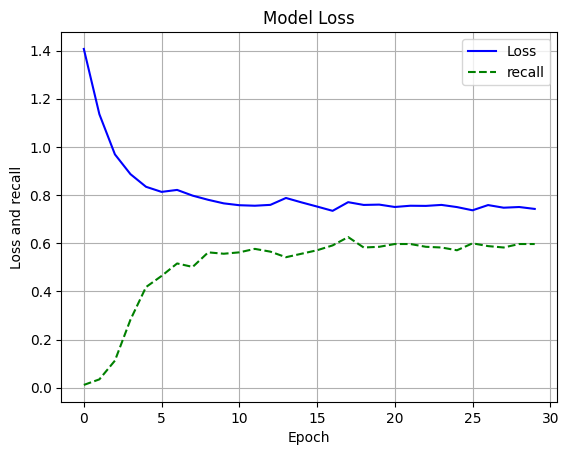

In [201]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history3.history['loss'], color='blue', linestyle='-')
plt.plot(history3.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'recall'])
plt.ylabel('Loss and recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [202]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_wv_prob_model3 = nn_wv_model3.predict(X_train_wv)
y_train_pred_nn_wv_model3 = (y_train_pred_nn_wv_prob_model3 > 0.5).astype(int)
y_train_pred_nn_wv_argmax_model3 = np.argmax(y_train_pred_nn_wv_model3, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_wv_prob_model3 = nn_wv_model3.predict(X_test_wv)
y_test_pred_nn_wv_model3 = (y_test_pred_nn_wv_prob_model3 > 0.5).astype(int)
y_test_pred_nn_wv_argmax_model3 = np.argmax(y_test_pred_nn_wv_model3, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [203]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_wv_argmax_model3) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_wv_argmax_model3) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_wv_argmax_model3[y_train_pred_nn_wv_argmax_model3 == old_val] = new_val
    y_test_pred_nn_wv_argmax_model3[y_test_pred_nn_wv_argmax_model3 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_wv_argmax_model3)
print(y_test_pred_nn_wv_argmax_model3)

Predictions before remapping the labels
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Predictions after remapping the labels
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Confusion Matric Train


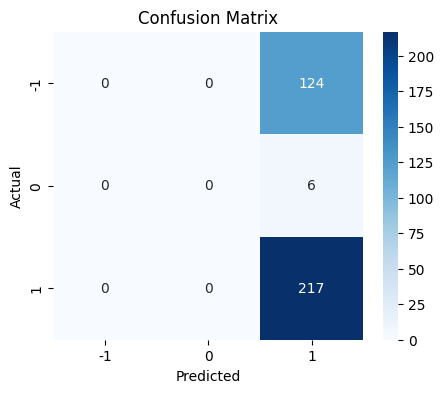

Confusion Matric Test


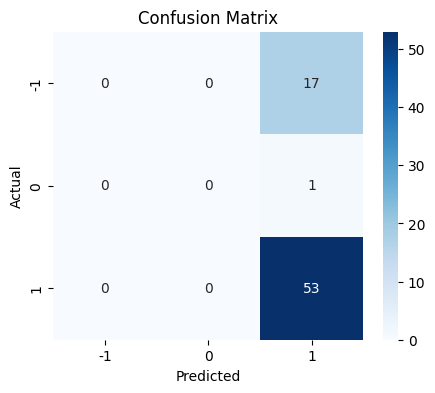

In [204]:
# Confusion Matrix
print('Confusion Matric Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_wv_argmax_model3)

print('Confusion Matric Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_wv_argmax_model3)

In [205]:
# Evaluation metrics for the model
eval_train_nn_wv_transformer_model3 = model_performance_classification_sklearn(y_train, y_train_pred_nn_wv_argmax_model3)
eval_test_nn_wv_transformer_model3 = model_performance_classification_sklearn(y_test, y_test_pred_nn_wv_argmax_model3)

print('Model 1 Evaluation')
print(eval_train_nn_wv_transformer_model1)
print(eval_test_nn_wv_transformer_model1)

print('\n Model 2 Evaluation')
print(eval_train_nn_wv_transformer_model2)
print(eval_test_nn_wv_transformer_model2)

print('\n Model 3 Evaluation')
print(eval_train_nn_wv_transformer_model3)
print(eval_test_nn_wv_transformer_model3)

Model 1 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381

 Model 2 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381

 Model 3 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381


Model Evalulation Summary:
* Model performance halted and it couldn't be improved.
* The best model achievable seems to be Model 3 so far which is less complex, but achives the same result as the previous ones
* Probably availability of more data can help with learning

##### Model 4 - Neural Network - Word2Vec

In [206]:
# removing the learning rate
# Changing the activation function to Leaky_ReLU

import gc

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_wv_model4 = Sequential()
nn_wv_model4.add(Input(shape=(X_train_wv.shape[1],)))
nn_wv_model4.add(Dense(64, activation='leaky_relu'))
nn_wv_model4.add(Dropout(0.2))
nn_wv_model4.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
# categorical_crossentropy loss function is a good option for multi class classification problems like the one we have for sentiment analysis
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_wv_model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall'])

# Summary
nn_wv_model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,459 (76.01 KB)

 Trainable params: 19,459 (76.01 KB)

 Non-trainable params: 0 (0.00 B)

In [207]:
# Training the model with 30 epochs and a batch_size of 64
import time
start_time = time.time()
history4 = nn_wv_model4.fit(X_train_wv, y_train_nn_ohe, epochs=30, batch_size=32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8920 - recall: 0.3042    
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7240 - recall: 0.5975 
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7238 - recall: 0.6182 
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7076 - recall: 0.6252 
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7133 - recall: 0.6203 
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7063 - recall: 0.6108 
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7147 - recall: 0.6257 
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7113 - recall: 0.6144 
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7158 - recall: 0.6224 
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7067 - recall: 0.6236 
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7164 - recall: 0.6257 
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7014 - recall: 0.6236

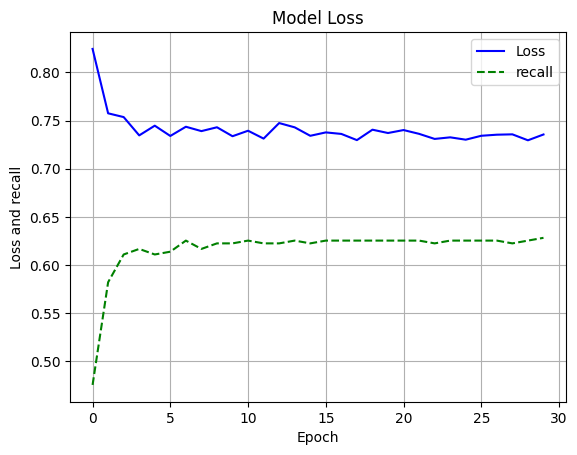

In [208]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history4.history['loss'], color='blue', linestyle='-')
plt.plot(history4.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'recall'])
plt.ylabel('Loss and recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [209]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_wv_prob_model4 = nn_wv_model4.predict(X_train_wv)
y_train_pred_nn_wv_model4 = (y_train_pred_nn_wv_prob_model4 > 0.5).astype(int)
y_train_pred_nn_wv_argmax_model4 = np.argmax(y_train_pred_nn_wv_model4, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_wv_prob_model4 = nn_wv_model4.predict(X_test_wv)
y_test_pred_nn_wv_model4 = (y_test_pred_nn_wv_prob_model4 > 0.5).astype(int)
y_test_pred_nn_wv_argmax_model4 = np.argmax(y_test_pred_nn_wv_model4, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [210]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_wv_argmax_model4) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_wv_argmax_model4) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_wv_argmax_model4[y_train_pred_nn_wv_argmax_model4 == old_val] = new_val
    y_test_pred_nn_wv_argmax_model4[y_test_pred_nn_wv_argmax_model4 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_wv_argmax_model4)
print(y_test_pred_nn_wv_argmax_model4)

Predictions before remapping the labels
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Predictions after remapping the labels
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Confusion Matric Train


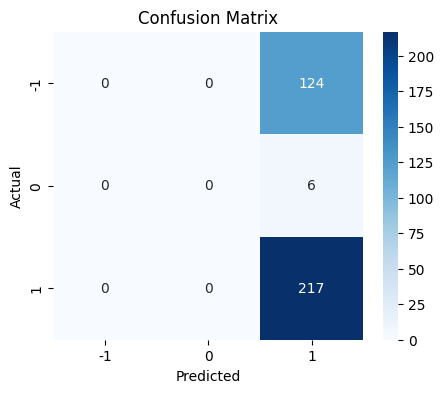

Confusion Matric Test


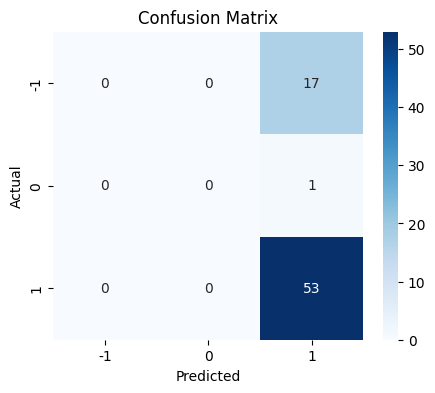

In [211]:
# Confusion Matrix
print('Confusion Matric Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_wv_argmax_model4)

print('Confusion Matric Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_wv_argmax_model4)

In [212]:
# Evaluation metrics for the model
eval_train_nn_wv_transformer_model4 = model_performance_classification_sklearn(y_train, y_train_pred_nn_wv_argmax_model4)
eval_test_nn_wv_transformer_model4 = model_performance_classification_sklearn(y_test, y_test_pred_nn_wv_argmax_model4)

print('Model 1 Evaluation')
print(eval_train_nn_wv_transformer_model1)
print(eval_test_nn_wv_transformer_model1)

print('\n Model 2 Evaluation')
print(eval_train_nn_wv_transformer_model2)
print(eval_test_nn_wv_transformer_model2)

print('\n Model 3 Evaluation')
print(eval_train_nn_wv_transformer_model3)
print(eval_test_nn_wv_transformer_model3)

print('\n Model 4 Evaluation')
print(eval_train_nn_wv_transformer_model4)
print(eval_test_nn_wv_transformer_model4)

Model 1 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381

 Model 2 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381

 Model 3 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381

 Model 4 Evaluation
   Accuracy  Recall  Precision      F1
0    0.6254  0.6254     0.3911  0.4812
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.5572  0.6381


Model Evalulation Summary:
* Same observation - Model performance halted and cant be improved
* The best model achievable seems to be Model 4 which is less complex, but achives the same result as the previous ones
* Probably availability of more data can help with learning

##### All Neural Network Word2Vec Model Comparisons

In [264]:
# All Neural Network Word2Vec evaluations put together
eval_train_nn_wv_transformer_model1['Model'] = 'Model_1_Neural Network Word2Vec'
eval_train_nn_wv_transformer_model2['Model'] = 'Model_2_Neural Network Word2Vec'
eval_train_nn_wv_transformer_model3['Model'] = 'Model_3_Neural Network Word2Vec'
eval_train_nn_wv_transformer_model4['Model'] = 'Model_4_Neural Network Word2Vec'

eval_test_nn_wv_transformer_model1['Model'] = 'Model_1_Neural Network Word2Vec'
eval_test_nn_wv_transformer_model2['Model'] = 'Model_2_Neural Network Word2Vec'
eval_test_nn_wv_transformer_model3['Model'] = 'Model_3_Neural Network Word2Vec'
eval_test_nn_wv_transformer_model4['Model'] = 'Model_4_Neural Network Word2Vec'


eval_train_nn_wv_transformer_model1['Type'] = 'Train'
eval_train_nn_wv_transformer_model2['Type'] = 'Train'
eval_train_nn_wv_transformer_model3['Type'] = 'Train'
eval_train_nn_wv_transformer_model4['Type'] = 'Train'

eval_test_nn_wv_transformer_model1['Type'] = 'Test'
eval_test_nn_wv_transformer_model2['Type'] = 'Test'
eval_test_nn_wv_transformer_model3['Type'] = 'Test'
eval_test_nn_wv_transformer_model4['Type'] = 'Test'

eval_train_nn_wv_transformer_model1['Hyperparameters'] = [{'Dense':(128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':30, 'batch_size':32 }]
eval_train_nn_wv_transformer_model2['Hyperparameters'] = [{'Dense':(256,128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':10, 'batch_size':64 }]
eval_train_nn_wv_transformer_model3['Hyperparameters'] = [{'Dense':(64), 'Dropout': 0.4, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': '0.0001', 'epochs':30, 'batch_size':64 }]
eval_train_nn_wv_transformer_model4['Hyperparameters'] = [{'Dense':(64), 'Dropout': 0.4, 'activation':['leaky_relu','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':30, 'batch_size':32 }]

eval_test_nn_wv_transformer_model1['Hyperparameters'] = [{'Dense':(128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':30, 'batch_size':32 }]
eval_test_nn_wv_transformer_model2['Hyperparameters'] = [{'Dense':(256,128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':10, 'batch_size':64 }]
eval_test_nn_wv_transformer_model3['Hyperparameters'] = [{'Dense':(64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': '0.0001', 'epochs':25, 'batch_size':32 }]
eval_test_nn_wv_transformer_model4['Hyperparameters'] = [{'Dense':(64), 'Dropout': 0.4, 'activation':['leaky_relu','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':30, 'batch_size':32 }]

In [265]:
eval_nn_wv_transformer = pd.concat([eval_train_nn_wv_transformer_model1, eval_train_nn_wv_transformer_model2, eval_train_nn_wv_transformer_model3,eval_train_nn_wv_transformer_model4, eval_test_nn_wv_transformer_model1, eval_test_nn_wv_transformer_model2, eval_test_nn_wv_transformer_model3,eval_test_nn_wv_transformer_model4])
eval_nn_wv_transformer[['Model', 'Type', 'Hyperparameters', 'Accuracy',	'Recall',	'Precision',	'F1']].sort_values(by=['Model', 'Type'])

,Model,Type,Hyperparameters,Accuracy,Recall,Precision,F1
0,Model_1_Neural Network Word2Vec,Test,"{'Dense': (128, 64), 'Dropout': 0.2, 'activati...",0.7465,0.7465,0.5572,0.6381
0,Model_1_Neural Network Word2Vec,Train,"{'Dense': (128, 64), 'Dropout': 0.2, 'activati...",0.6254,0.6254,0.3911,0.4812
0,Model_2_Neural Network Word2Vec,Test,"{'Dense': (256, 128, 64), 'Dropout': 0.2, 'act...",0.7465,0.7465,0.5572,0.6381
0,Model_2_Neural Network Word2Vec,Train,"{'Dense': (256, 128, 64), 'Dropout': 0.2, 'act...",0.6254,0.6254,0.3911,0.4812
0,Model_3_Neural Network Word2Vec,Test,"{'Dense': 64, 'Dropout': 0.2, 'activation': ['...",0.7465,0.7465,0.5572,0.6381
0,Model_3_Neural Network Word2Vec,Train,"{'Dense': 64, 'Dropout': 0.4, 'activation': ['...",0.6254,0.6254,0.3911,0.4812
0,Model_4_Neural Network Word2Vec,Test,"{'Dense': 64, 'Dropout': 0.4, 'activation': ['...",0.7465,0.7465,0.5572,0.6381
0,Model_4_Neural Network Word2Vec,Train,"{'Dense': 64, 'Dropout': 0.4, 'activation': ['...",0.6254,0.6254,0.3911,0.4812


Final Model Selection

Based on the model evaluations it looks like best pick will be model 4 with very minimal complexity but performing the same as others

#### **Neural Network Model on Sentence Transformer**

##### Model 1 - Neural Network - Sentence Transformer

In [216]:
import gc
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_st_model1 = Sequential()
nn_st_model1.add(Input(shape=(X_train_st.shape[1],)))
nn_st_model1.add(Dense(128, activation='tanh'))
nn_st_model1.add(Dropout(0.2))
nn_st_model1.add(Dense(64, activation='tanh'))
nn_st_model1.add(Dropout(0.2))
nn_st_model1.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
nn_st_model1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['recall'])

# Summary
nn_st_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

In [217]:
# Fit the model - 10 epochs and batch size of 64
import time
start_time = time.time()
history_st = nn_st_model1.fit(X_train_st, y_train_nn_ohe, epochs=10, batch_size=64)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9941 - recall: 0.0302   
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7543 - recall: 0.5584 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6769 - recall: 0.5977 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6321 - recall: 0.6513 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5979 - recall: 0.7001 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5683 - recall: 0.7335 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5558 - recall: 0.7244 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5115 - recall: 0.7560 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5129 - recall: 0.7503 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4884 - recall: 0.7804 
Training time: 3.8990137577056885 seconds


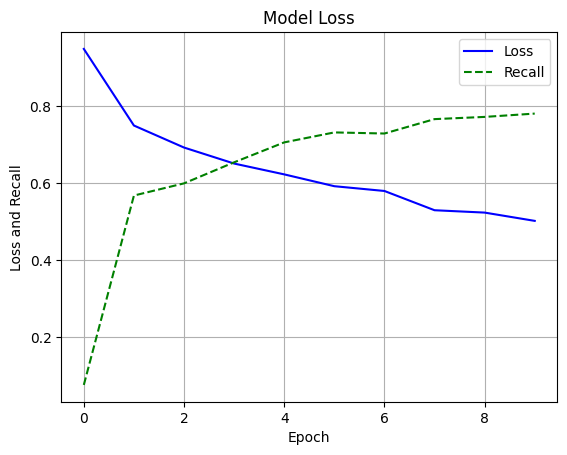

In [218]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history_st.history['loss'], color='blue', linestyle='-')
plt.plot(history_st.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'Recall'])
plt.ylabel('Loss and Recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [219]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_st_prob_model1 = nn_st_model1.predict(X_train_st)
y_train_pred_nn_st_model1 = (y_train_pred_nn_st_prob_model1 > 0.5).astype(int)
y_train_pred_nn_st_argmax_model1 = np.argmax(y_train_pred_nn_st_model1, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_st_prob_model1 = nn_st_model1.predict(X_test_st)
y_test_pred_nn_st_model1 = (y_test_pred_nn_st_prob_model1 > 0.5).astype(int)
y_test_pred_nn_st_argmax_model1 = np.argmax(y_test_pred_nn_st_model1, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [220]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_st_argmax_model1) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_st_argmax_model1) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_st_argmax_model1[y_train_pred_nn_st_argmax_model1 == old_val] = new_val
    y_test_pred_nn_st_argmax_model1[y_test_pred_nn_st_argmax_model1 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_st_argmax_model1)
print(y_test_pred_nn_st_argmax_model1)

Predictions before remapping the labels
[0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 2 2 2 0 0 0 2 2 0 2 0 0 2 0 2 2 0 2 2 2 2 0
 0 0 2 2 0 0 0 0 0 0 0 2 0 0 2 0 2 2 2 2 0 2 2 2 2 2 2 0 0 0 2 0 0 2 0 0 2
 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 0 2 0 2 2 0 2 0 0 2 2 0 2 2 2 2 0
 0 2 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 0 0 0 2 0 0 0 0 0 0 0 2 2
 2 2 0 2 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 0
 2 2 0 2 2 2 2 2 2 2 2 0 2 2 0 0 0 2 2 0 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2
 2 2 2 0 2 2 0 2 2 2 2 2 0 0 2 0 0 2 2 2 2 0 0 0 2 2 2 0 2 0 2 0 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 0 2 2 0 0 2 2 2 2 2 0 2 0 2 2 2 2 2 2 0
 0 2 2 2 0 2 0 0 2 2 2 2 2 0]
[2 2 0 0 0 0 2 0 2 0 0 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2]
Predictions after remapping the labels
[-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1  1  1 -

Confusion Matrix Train


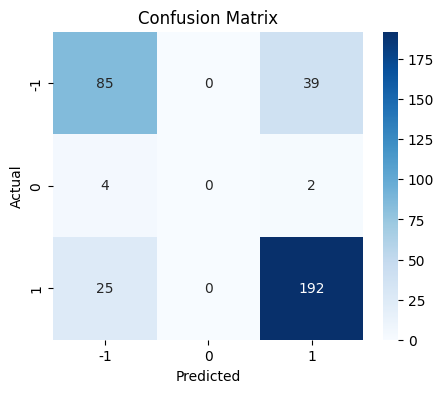

Confusion Matrix Test


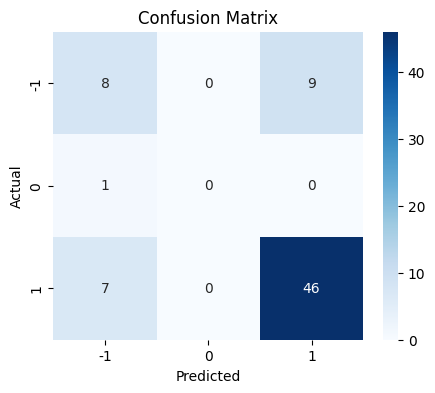

In [221]:
# Confusion Matrix
print('Confusion Matrix Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_st_argmax_model1)

print('Confusion Matrix Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_st_argmax_model1)

In [222]:
# Evaluation metrics for the model
eval_train_nn_st_transformer_model1 = model_performance_classification_sklearn(y_train, y_train_pred_nn_st_argmax_model1)
eval_test_nn_st_transformer_model1 = model_performance_classification_sklearn(y_test, y_test_pred_nn_st_argmax_model1)
print(eval_train_nn_st_transformer_model1)
print(eval_test_nn_st_transformer_model1)

   Accuracy  Recall  Precision      F1
0    0.7983  0.7983     0.7818  0.7889
   Accuracy  Recall  Precision     F1
0    0.7606  0.7606      0.744  0.752


Model Evalulation Summary:
* Model is performing much better than Word2Vec
* The Test eveluation scores can be improved


##### Model 2 - Neural Network - Sentence Transformer

In [223]:
# Increasing the number of dense layers to 3

import gc
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_st_model2 = Sequential()
nn_st_model2.add(Input(shape=(X_train_st.shape[1],)))
nn_st_model2.add(Dense(256, activation='tanh'))
nn_st_model2.add(Dropout(0.2))
nn_st_model2.add(Dense(128, activation='tanh'))
nn_st_model2.add(Dropout(0.2))
nn_st_model2.add(Dense(64, activation='tanh'))
nn_st_model2.add(Dropout(0.2))
nn_st_model2.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
nn_st_model2.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['recall'])

# Summary
nn_st_model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,907 (546.51 KB)

 Trainable params: 139,907 (546.51 KB)

 Non-trainable params: 0 (0.00 B)

In [224]:
# Fit the model - 10 epochs and batch size of 64
import time
start_time = time.time()
history_st = nn_st_model2.fit(X_train_st, y_train_nn_ohe, epochs=10, batch_size=64)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0022 - recall: 0.0776  
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7033 - recall: 0.6144
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6525 - recall: 0.6719
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6043 - recall: 0.6832
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5380 - recall: 0.7812
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4996 - recall: 0.7559
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4725 - recall: 0.7806
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4615 - recall: 0.7606
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4282 - recall: 0.7869
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4076 - recall: 0.8138
Training time: 2.6981425285339355 seconds


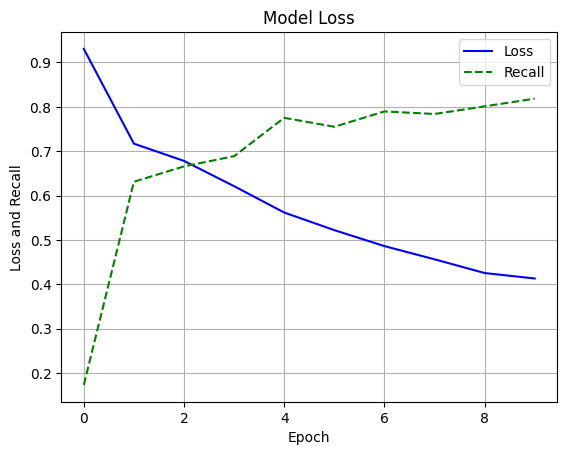

In [225]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history_st.history['loss'], color='blue', linestyle='-')
plt.plot(history_st.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'Recall'])
plt.ylabel('Loss and Recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [226]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_st_prob_model2 = nn_st_model2.predict(X_train_st)
y_train_pred_nn_st_model2 = (y_train_pred_nn_st_prob_model2 > 0.5).astype(int)
y_train_pred_nn_st_argmax_model2 = np.argmax(y_train_pred_nn_st_model2, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_st_prob_model2 = nn_st_model2.predict(X_test_st)
y_test_pred_nn_st_model2 = (y_test_pred_nn_st_prob_model2 > 0.5).astype(int)
y_test_pred_nn_st_argmax_model2 = np.argmax(y_test_pred_nn_st_model2, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [227]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_st_argmax_model2) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_st_argmax_model2) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_st_argmax_model2[y_train_pred_nn_st_argmax_model2 == old_val] = new_val
    y_test_pred_nn_st_argmax_model2[y_test_pred_nn_st_argmax_model2 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_st_argmax_model2)
print(y_test_pred_nn_st_argmax_model2)

Predictions before remapping the labels
[0 0 2 0 0 0 0 0 2 0 0 0 2 0 2 2 0 2 0 0 0 2 2 0 2 0 0 2 0 2 2 0 2 2 2 2 0
 0 0 0 2 0 0 2 0 0 0 0 2 0 0 2 0 0 2 2 2 0 2 2 2 2 2 2 0 0 0 2 0 0 2 0 0 2
 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 0 2 2 0 2 2 0 2 2 0 2 0 2 2 2
 2 2 0 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 0 2 0 0 2 0 0 0 0 2 2
 2 2 0 2 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 0 2 2 0 2 0 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 0 0 2 2 0 2 2 2 2 0 2 0 2 2 2 0 2 2 2 0 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 0 2 2 2 0 2 2 2 2 2 0 2 0 2 2 2 2 2 2 0
 0 2 2 2 0 2 0 0 2 2 2 2 2 0]
[2 2 2 2 0 0 2 2 2 0 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 0 2 2 2 0 2 2 0 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2]
Predictions after remapping the labels
[-1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1 -1  1 -1 -1 -1  1  1 -

Confusion Matrix Train


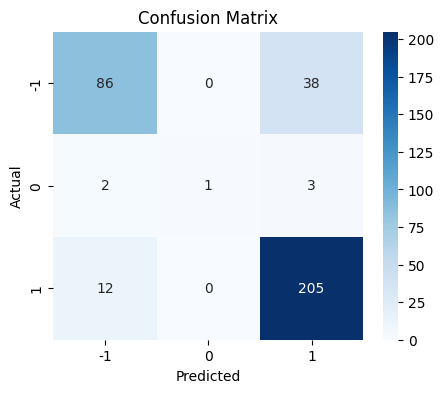

Confusion Matrix Test


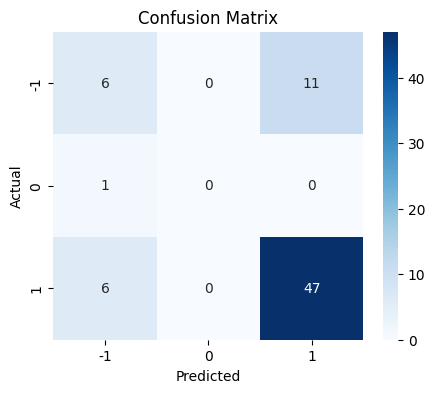

In [228]:
# Confusion Matrix
print('Confusion Matrix Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_st_argmax_model2)

print('Confusion Matrix Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_st_argmax_model2)

In [230]:
# Evaluation metrics for the model
eval_train_nn_st_transformer_model2 = model_performance_classification_sklearn(y_train, y_train_pred_nn_st_argmax_model2)
eval_test_nn_st_transformer_model2 = model_performance_classification_sklearn(y_test, y_test_pred_nn_st_argmax_model2)
print('Model 1 - Evaluation')
print(eval_train_nn_st_transformer_model1)
print(eval_test_nn_st_transformer_model1)

print('\n Model 2 - Evaluation')
print(eval_train_nn_st_transformer_model2)
print(eval_test_nn_st_transformer_model2)

Model 1 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.7983  0.7983     0.7818  0.7889
   Accuracy  Recall  Precision     F1
0    0.7606  0.7606      0.744  0.752

 Model 2 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.8415  0.8415     0.8457  0.8331
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.7154  0.7279


Model Evalulation Summary:
* Increasing the number of dense layers did not increase the prediction on test data

May be increasing the epochs or reducing the batch size may help


##### Model 3 - Neural Network - Sentence Transformer

In [231]:
# Reducing the dense layers back to 2

import gc
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_st_model3 = Sequential()
nn_st_model3.add(Input(shape=(X_train_st.shape[1],)))
nn_st_model3.add(Dense(128, activation='tanh'))
nn_st_model3.add(Dropout(0.2))
nn_st_model3.add(Dense(64, activation='tanh'))
nn_st_model3.add(Dropout(0.2))
nn_st_model3.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
nn_st_model3.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['recall'])

# Summary
nn_st_model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

In [232]:
# Fit the model - 20 epochs and batch size of 32
import time
start_time = time.time()
history_st = nn_st_model3.fit(X_train_st, y_train_nn_ohe, epochs=20, batch_size=32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9683 - recall: 0.1601    
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7097 - recall: 0.6144 
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6354 - recall: 0.6742 
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5786 - recall: 0.6954 
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5418 - recall: 0.7588 
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5255 - recall: 0.7359 
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4975 - recall: 0.7554 
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4636 - recall: 0.7846 
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4385 - recall: 0.8256 
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4013 - recall: 0.8165 
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3976 - recall: 0.8019 
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3671 - recall: 0.8498

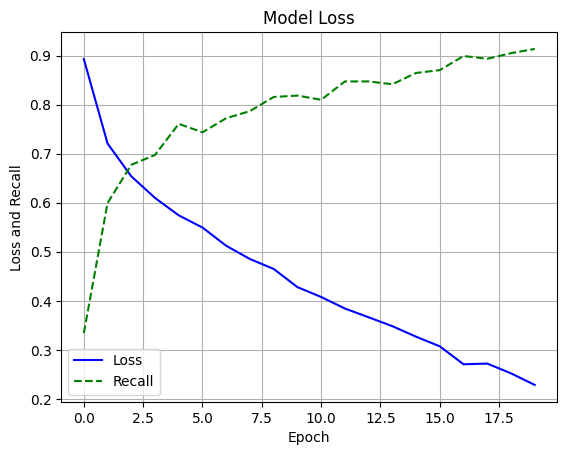

In [233]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history_st.history['loss'], color='blue', linestyle='-')
plt.plot(history_st.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'Recall'])
plt.ylabel('Loss and Recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [234]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_st_prob_model3 = nn_st_model3.predict(X_train_st)
y_train_pred_nn_st_model3 = (y_train_pred_nn_st_prob_model3 > 0.5).astype(int)
y_train_pred_nn_st_argmax_model3 = np.argmax(y_train_pred_nn_st_model3, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_st_prob_model3 = nn_st_model3.predict(X_test_st)
y_test_pred_nn_st_model3 = (y_test_pred_nn_st_prob_model3 > 0.5).astype(int)
y_test_pred_nn_st_argmax_model3 = np.argmax(y_test_pred_nn_st_model3, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [235]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_st_argmax_model3) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_st_argmax_model3) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_st_argmax_model3[y_train_pred_nn_st_argmax_model3 == old_val] = new_val
    y_test_pred_nn_st_argmax_model3[y_test_pred_nn_st_argmax_model3 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_st_argmax_model3)
print(y_test_pred_nn_st_argmax_model3)

Predictions before remapping the labels
[0 0 0 0 0 0 2 1 2 0 0 0 2 0 0 2 0 2 0 0 0 2 0 0 2 0 0 2 2 2 2 0 2 0 2 2 0
 0 0 0 2 0 0 2 0 0 0 0 2 0 0 2 0 0 2 2 2 2 1 2 2 2 2 2 0 0 0 2 0 0 2 0 0 2
 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 0 2 2 0 2 0 2 0 0
 2 0 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 0 2 0 0 2 0 0 0 0 2 2
 2 2 2 2 0 2 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 0 0 0 2 0 2 0 2 2 2 2 2 0 2 2 0 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 0 0 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 0 2 0 2 2 2 0 0 2 2 0 2 2 2 2 0 2 0 2 0 2 0 2 2 2 0 2 0 2 0 2
 2 2 0 0 2 2 2 2 2 0 0 0 0 2 0 2 2 0 2 2 2 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2
 2 2 2 2 0 2 0 0 2 2 0 2 2 0]
[2 2 2 0 0 0 2 2 2 0 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0 2 0 2 2 0 2 2 0 2 2 2 0 2 2 0 2 2 0 0 2 0 2 2 2 0 2 0 2 2 2 2 2]
Predictions after remapping the labels
[-1 -1 -1 -1 -1 -1  1  0  1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -

Confusion Matrix Train


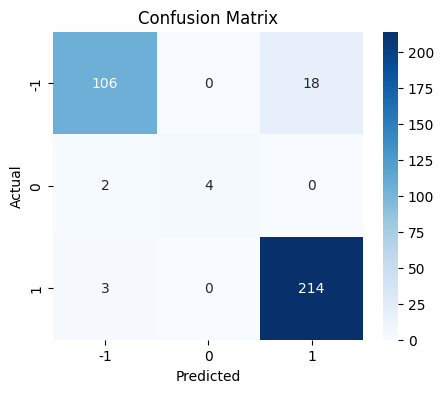

Confusion Matrix Test


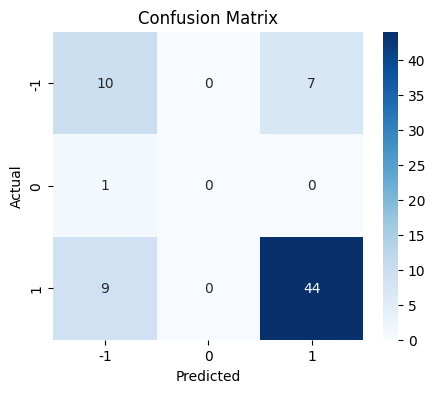

In [236]:
# Confusion Matrix
print('Confusion Matrix Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_st_argmax_model3)

print('Confusion Matrix Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_st_argmax_model3)

In [237]:
# Evaluation metrics for the model
eval_train_nn_st_transformer_model3 = model_performance_classification_sklearn(y_train, y_train_pred_nn_st_argmax_model3)
eval_test_nn_st_transformer_model3 = model_performance_classification_sklearn(y_test, y_test_pred_nn_st_argmax_model3)
print('Model 1 - Evaluation')
print(eval_train_nn_st_transformer_model1)
print(eval_test_nn_st_transformer_model1)

print('\n Model 2 - Evaluation')
print(eval_train_nn_st_transformer_model2)
print(eval_test_nn_st_transformer_model2)

print('\n Model 3 - Evaluation')
print(eval_train_nn_st_transformer_model3)
print(eval_test_nn_st_transformer_model3)

Model 1 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.7983  0.7983     0.7818  0.7889
   Accuracy  Recall  Precision     F1
0    0.7606  0.7606      0.744  0.752

 Model 2 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.8415  0.8415     0.8457  0.8331
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.7154  0.7279

 Model 3 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.9337  0.9337     0.9354  0.9323
   Accuracy  Recall  Precision      F1
0    0.7606  0.7606     0.7637  0.7611


Model Evalulation Summary:
* Increasing number of epochs and reducing the batch size caused improvements in training predictions.
* There is only slight improvement with testing data.

May be increasing the dropout percentage might help


##### Model 4 - Neural Network - Sentence Transformer

In [238]:
# Increasing the dropout to 0.4

import gc
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_st_model4 = Sequential()
nn_st_model4.add(Input(shape=(X_train_st.shape[1],)))
nn_st_model4.add(Dense(128, activation='tanh'))
nn_st_model4.add(Dropout(0.4))
nn_st_model4.add(Dense(64, activation='tanh'))
nn_st_model4.add(Dropout(0.4))
nn_st_model4.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
nn_st_model4.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['recall'])

# Summary
nn_st_model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

In [239]:
# Fit the model - 20 epochs and batch size of 32
import time
start_time = time.time()
history_st = nn_st_model4.fit(X_train_st, y_train_nn_ohe, epochs=20, batch_size=32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9457 - recall: 0.1500    
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7229 - recall: 0.5938 
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6452 - recall: 0.6377
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6276 - recall: 0.6324
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6032 - recall: 0.6831 
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5722 - recall: 0.7123
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5290 - recall: 0.7570  
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4915 - recall: 0.7772
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4909 - recall: 0.7547  
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4707 - recall: 0.7650 
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4552 - recall: 0.7688 
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4342 - recall: 0.7891

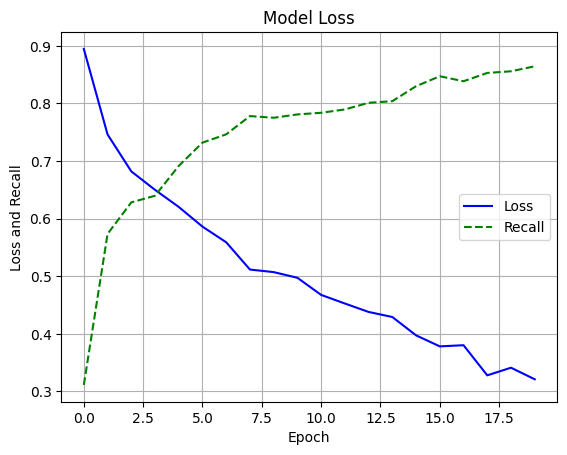

In [240]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history_st.history['loss'], color='blue', linestyle='-')
plt.plot(history_st.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'Recall'])
plt.ylabel('Loss and Recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [241]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_st_prob_model4 = nn_st_model4.predict(X_train_st)
y_train_pred_nn_st_model4 = (y_train_pred_nn_st_prob_model4 > 0.5).astype(int)
y_train_pred_nn_st_argmax_model4 = np.argmax(y_train_pred_nn_st_model4, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_st_prob_model4 = nn_st_model4.predict(X_test_st)
y_test_pred_nn_st_model4 = (y_test_pred_nn_st_prob_model4 > 0.5).astype(int)
y_test_pred_nn_st_argmax_model4 = np.argmax(y_test_pred_nn_st_model4, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [242]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_st_argmax_model4) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_st_argmax_model4) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_st_argmax_model4[y_train_pred_nn_st_argmax_model4 == old_val] = new_val
    y_test_pred_nn_st_argmax_model4[y_test_pred_nn_st_argmax_model4 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_st_argmax_model4)
print(y_test_pred_nn_st_argmax_model4)

Predictions before remapping the labels
[0 0 0 0 0 0 2 1 2 0 0 0 2 0 0 2 0 2 0 0 2 2 0 0 2 0 0 2 0 2 2 0 2 0 2 2 0
 0 0 0 2 0 0 0 0 0 0 0 2 0 0 2 0 0 2 2 2 0 1 2 2 2 2 2 0 0 0 2 0 0 2 0 0 2
 2 2 2 0 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 2 0 2 2 0 2 2 0 2 2 0 2 0 2 0 0
 2 0 0 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 0 2 0 2 0 0 2 0 0 0 0 2 2
 2 2 0 2 0 2 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 0
 2 2 0 2 2 2 2 2 2 2 0 2 2 2 0 0 0 0 2 0 2 0 2 2 2 2 2 0 2 2 0 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 0 2 0 2 2 2 0 0 2 2 0 2 2 2 2 0 2 0 2 0 2 0 2 2 2 0 2 0 0 0 2
 2 2 2 0 2 2 2 2 2 2 2 0 2 2 0 2 2 0 2 2 2 0 2 2 2 2 2 0 2 0 2 2 0 2 2 2 2
 0 2 2 2 0 2 0 0 2 2 0 2 2 0]
[2 2 0 0 0 0 2 0 2 0 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0 2 0 2 2 0 2 2 0 2 2 2 0 2 2 0 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2]
Predictions after remapping the labels
[-1 -1 -1 -1 -1 -1  1  0  1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1  1  1 -1 -

Confusion Matrix Train


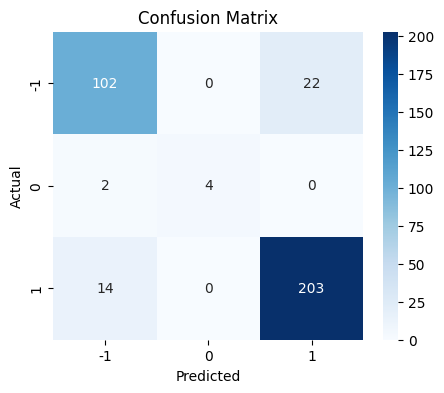

Confusion Matrix Test


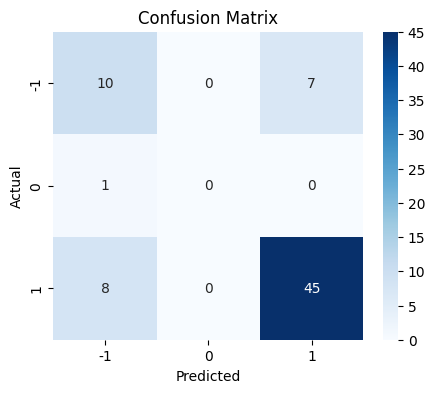

In [243]:
# Confusion Matrix
print('Confusion Matrix Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_st_argmax_model4)

print('Confusion Matrix Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_st_argmax_model4)

In [244]:
# Evaluation metrics for the model
eval_train_nn_st_transformer_model4 = model_performance_classification_sklearn(y_train, y_train_pred_nn_st_argmax_model4)
eval_test_nn_st_transformer_model4 = model_performance_classification_sklearn(y_test, y_test_pred_nn_st_argmax_model4)
print('Model 1 - Evaluation')
print(eval_train_nn_st_transformer_model1)
print(eval_test_nn_st_transformer_model1)

print('\n Model 2 - Evaluation')
print(eval_train_nn_st_transformer_model2)
print(eval_test_nn_st_transformer_model2)

print('\n Model 3 - Evaluation')
print(eval_train_nn_st_transformer_model3)
print(eval_test_nn_st_transformer_model3)

print('\n Model 4 - Evaluation')
print(eval_train_nn_st_transformer_model4)
print(eval_test_nn_st_transformer_model4)

Model 1 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.7983  0.7983     0.7818  0.7889
   Accuracy  Recall  Precision     F1
0    0.7606  0.7606      0.744  0.752

 Model 2 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.8415  0.8415     0.8457  0.8331
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.7154  0.7279

 Model 3 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.9337  0.9337     0.9354  0.9323
   Accuracy  Recall  Precision      F1
0    0.7606  0.7606     0.7637  0.7611

 Model 4 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.8905  0.8905     0.8904  0.8895
   Accuracy  Recall  Precision      F1
0    0.7746  0.7746      0.772  0.7729


Model Evalulation Summary:
* Looks like increasing the dropout rate has improved the test metrics a little
* The training metrics are higher buut in range of test data metrics which says the model is not memorizing the data

Increaing the neurons and the number of layers might make the model predict better


##### Model 5 - Neural Network - Sentence Transformer

In [245]:
# Increasing the dropout to 0.4 and increasing the neurons in dense layer 1 and dense layer 2

import gc
tf.keras.backend.clear_session()
gc.collect()

# Build the model
nn_st_model5 = Sequential()
nn_st_model5.add(Input(shape=(X_train_st.shape[1],)))
nn_st_model5.add(Dense(256, activation='tanh'))
nn_st_model5.add(Dropout(0.4))
nn_st_model5.add(Dense(128, activation='tanh'))
nn_st_model5.add(Dropout(0.4))
nn_st_model5.add(Dense(3, activation='softmax')) # Output class (3 labels - positive, neutral and negative)

# Compile the model
nn_st_model5.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['recall'])

# Summary
nn_st_model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,843 (515.01 KB)

 Trainable params: 131,843 (515.01 KB)

 Non-trainable params: 0 (0.00 B)

In [246]:
# Fit the model - 25 epochs and batch size of 32
import time
start_time = time.time()
history_st = nn_st_model5.fit(X_train_st, y_train_nn_ohe, epochs=25, batch_size=32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9149 - recall: 0.2365    
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6572 - recall: 0.6361 
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6116 - recall: 0.6778 
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5379 - recall: 0.7266
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5139 - recall: 0.7122
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4977 - recall: 0.7636
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4567 - recall: 0.7814 
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4313 - recall: 0.7957 
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4226 - recall: 0.7845 
Epoch 10/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4001 - recall: 0.8122 
Epoch 11/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3814 - recall: 0.8207 
Epoch 12/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3755 - recall: 0.8178

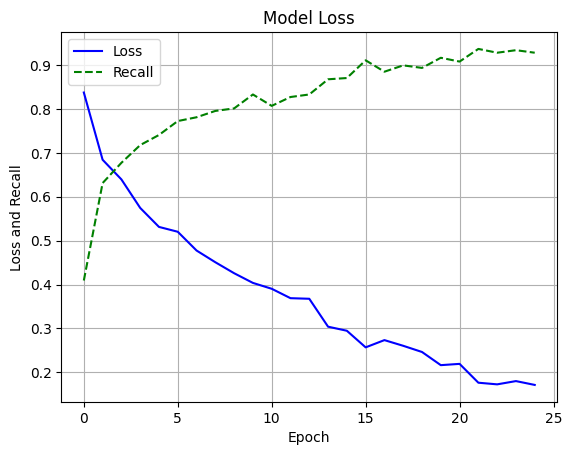

In [247]:
# Plotting to see how loss and recall varies with each epoch
plt.plot(history_st.history['loss'], color='blue', linestyle='-')
plt.plot(history_st.history['recall'], color = 'green', linestyle='--')
plt.title('Model Loss')
plt.legend(['Loss', 'Recall'])
plt.ylabel('Loss and Recall')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

###### Model Evaluation

In [248]:
# Training data prediction - Word2Vec Neural Network
y_train_pred_nn_st_prob_model5 = nn_st_model5.predict(X_train_st)
y_train_pred_nn_st_model5 = (y_train_pred_nn_st_prob_model5 > 0.5).astype(int)
y_train_pred_nn_st_argmax_model5 = np.argmax(y_train_pred_nn_st_model5, axis=1)

# Testing data prediction - Word2Vec Neural Network
y_test_pred_nn_st_prob_model5 = nn_st_model5.predict(X_test_st)
y_test_pred_nn_st_model5 = (y_test_pred_nn_st_prob_model5 > 0.5).astype(int)
y_test_pred_nn_st_argmax_model5 = np.argmax(y_test_pred_nn_st_model5, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [249]:
print('Predictions before remapping the labels')
print(y_train_pred_nn_st_argmax_model5) # Checking the output of the train prediction using Word2Vec transformer
print(y_test_pred_nn_st_argmax_model5) # Checking the output of the test prediction using Word2Vec transformer
# Remapping the labels to be what it is used to be in the original dataset
label_remap = {0:-1, 1:0, 2: 1} # -1: Negative, 0: Neural, 1: Positive
for old_val, new_val in label_remap.items():
    y_train_pred_nn_st_argmax_model5[y_train_pred_nn_st_argmax_model5 == old_val] = new_val
    y_test_pred_nn_st_argmax_model5[y_test_pred_nn_st_argmax_model5 == old_val] = new_val

print('Predictions after remapping the labels')
print(y_train_pred_nn_st_argmax_model5)
print(y_test_pred_nn_st_argmax_model5)

Predictions before remapping the labels
[2 0 1 0 2 0 2 1 2 0 0 0 2 0 2 2 0 2 0 0 0 2 0 0 2 0 0 2 2 2 2 0 2 0 2 2 0
 0 0 0 2 0 2 2 2 0 0 0 2 0 0 2 0 0 2 2 2 2 1 2 2 2 2 2 0 0 2 2 0 0 2 0 0 2
 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 0 2 2 0 2 0 2 0 0
 2 1 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 0 2 0 0 0 0 0 0 0 2 2
 2 2 2 2 0 2 2 0 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 0 0 2 2 0 2 0 2 2 2 2 2 0 2 2 0 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 0 0 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 0 2 0 2 2 2 0 0 2 2 0 2 2 2 2 0 2 0 2 0 2 0 2 2 2 0 2 0 2 0 2
 2 2 0 2 2 2 2 2 2 0 0 0 2 2 0 2 2 0 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 0 0 2 2 0 2 2 0]
[2 2 2 0 0 0 2 2 2 0 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0 2 0 2 2 0 2 2 2 2 2 2 0 2 2 0 2 2 2 0 2 0 2 2 2 0 2 0 2 2 2 2 2]
Predictions after remapping the labels
[ 1 -1  0 -1  1 -1  1  0  1 -1 -1 -1  1 -1  1  1 -1  1 -1 -1 -1  1 -1 -

Confusion Matrix Train


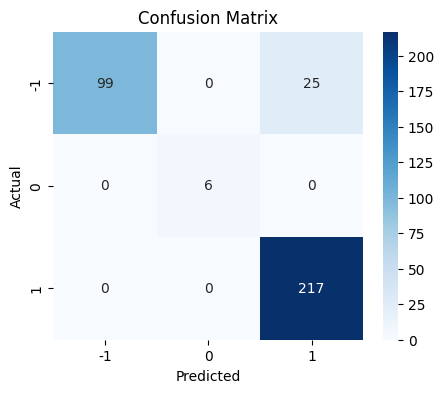

Confusion Matrix Test


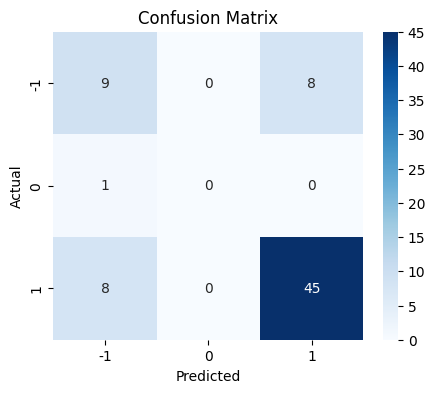

In [250]:
# Confusion Matrix
print('Confusion Matrix Train')
cm = plot_confusion_matrix(y_train, y_train_pred_nn_st_argmax_model5)

print('Confusion Matrix Test')
cm = plot_confusion_matrix(y_test, y_test_pred_nn_st_argmax_model5)

In [251]:
# Evaluation metrics for the model
eval_train_nn_st_transformer_model5 = model_performance_classification_sklearn(y_train, y_train_pred_nn_st_argmax_model5)
eval_test_nn_st_transformer_model5 = model_performance_classification_sklearn(y_test, y_test_pred_nn_st_argmax_model5)
print('Model 1 - Evaluation')
print(eval_train_nn_st_transformer_model1)
print(eval_test_nn_st_transformer_model1)

print('\n Model 2 - Evaluation')
print(eval_train_nn_st_transformer_model2)
print(eval_test_nn_st_transformer_model2)

print('\n Model 3 - Evaluation')
print(eval_train_nn_st_transformer_model3)
print(eval_test_nn_st_transformer_model3)

print('\n Model 4 - Evaluation')
print(eval_train_nn_st_transformer_model4)
print(eval_test_nn_st_transformer_model4)

print('\n Model 5 - Evaluation')
print(eval_train_nn_st_transformer_model5)
print(eval_test_nn_st_transformer_model5)

Model 1 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.7983  0.7983     0.7818  0.7889
   Accuracy  Recall  Precision     F1
0    0.7606  0.7606      0.744  0.752

 Model 2 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.8415  0.8415     0.8457  0.8331
   Accuracy  Recall  Precision      F1
0    0.7465  0.7465     0.7154  0.7279

 Model 3 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.9337  0.9337     0.9354  0.9323
   Accuracy  Recall  Precision      F1
0    0.7606  0.7606     0.7637  0.7611

 Model 4 - Evaluation
   Accuracy  Recall  Precision      F1
0    0.8905  0.8905     0.8904  0.8895
   Accuracy  Recall  Precision      F1
0    0.7746  0.7746      0.772  0.7729

 Model 5 - Evaluation
   Accuracy  Recall  Precision      F1
0     0.928   0.928     0.9354  0.9259
   Accuracy  Recall  Precision      F1
0    0.7606  0.7606     0.7535  0.7569


Model Evalulation Summary:
* Looks like increasing the neurons did not help much with predicting the unseen data accurately. The metrics did not seem to improve.

Based on the different models we have, the best one to choose will be model 4 which has better recall amd f1 score over the other models


##### All Neural Network Sentence Transformer Model Comparisons

In [266]:
# All Random Forest Word2Vec evaluations put together
eval_train_nn_st_transformer_model1['Model'] = 'Model_1_Neural Network Sentence Transformer'
eval_train_nn_st_transformer_model2['Model'] = 'Model_2_Neural Network Sentence Transformer'
eval_train_nn_st_transformer_model3['Model'] = 'Model_3_Neural Network Sentence Transformer'
eval_train_nn_st_transformer_model4['Model'] = 'Model_4_Neural Network Sentence Transformer'
eval_train_nn_st_transformer_model5['Model'] = 'Model_5_Neural Network Sentence Transformer'

eval_test_nn_st_transformer_model1['Model'] = 'Model_1_Neural Network Sentence Transformer'
eval_test_nn_st_transformer_model2['Model'] = 'Model_2_Neural Network Sentence Transformer'
eval_test_nn_st_transformer_model3['Model'] = 'Model_3_Neural Network Sentence Transformer'
eval_test_nn_st_transformer_model4['Model'] = 'Model_4_Neural Network Sentence Transformer'
eval_test_nn_st_transformer_model5['Model'] = 'Model_5_Neural Network Sentence Transformer'


eval_train_nn_st_transformer_model1['Type'] = 'Train'
eval_train_nn_st_transformer_model2['Type'] = 'Train'
eval_train_nn_st_transformer_model3['Type'] = 'Train'
eval_train_nn_st_transformer_model4['Type'] = 'Train'
eval_train_nn_st_transformer_model5['Type'] = 'Train'

eval_test_nn_st_transformer_model1['Type'] = 'Test'
eval_test_nn_st_transformer_model2['Type'] = 'Test'
eval_test_nn_st_transformer_model3['Type'] = 'Test'
eval_test_nn_st_transformer_model4['Type'] = 'Test'
eval_test_nn_st_transformer_model5['Type'] = 'Test'

eval_train_nn_st_transformer_model1['Hyperparameters'] = [{'Dense':(128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':10, 'batch_size':64 }]
eval_train_nn_st_transformer_model2['Hyperparameters'] = [{'Dense':(256,128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':10, 'batch_size':64 }]
eval_train_nn_st_transformer_model3['Hyperparameters'] = [{'Dense':(128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':20, 'batch_size':32 }]
eval_train_nn_st_transformer_model4['Hyperparameters'] = [{'Dense':(128,64), 'Dropout': 0.4, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':20, 'batch_size':32 }]
eval_train_nn_st_transformer_model5['Hyperparameters'] = [{'Dense':(256,128), 'Dropout': 0.4, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':25, 'batch_size':32 }]


eval_test_nn_st_transformer_model1['Hyperparameters'] = [{'Dense':(128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':10, 'batch_size':64 }]
eval_test_nn_st_transformer_model2['Hyperparameters'] = [{'Dense':(256,128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':10, 'batch_size':64 }]
eval_test_nn_st_transformer_model3['Hyperparameters'] = [{'Dense':(128,64), 'Dropout': 0.2, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':20, 'batch_size':32 }]
eval_test_nn_st_transformer_model4['Hyperparameters'] = [{'Dense':(128,64), 'Dropout': 0.4, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':20, 'batch_size':32 }]
eval_test_nn_st_transformer_model5['Hyperparameters'] = [{'Dense':(256,128), 'Dropout': 0.4, 'activation':['tanh','softmax'], 'optimizer':'adam', 'loss': 'categorical_crossentropy', 'learning_rate': 'default', 'epochs':25, 'batch_size':32 }]

In [267]:
eval_nn_st_transformer = pd.concat([eval_train_nn_st_transformer_model1, eval_train_nn_st_transformer_model2, eval_train_nn_st_transformer_model3, eval_train_nn_st_transformer_model4, eval_train_nn_st_transformer_model5, eval_test_nn_st_transformer_model1, eval_test_nn_st_transformer_model2, eval_test_nn_st_transformer_model3, eval_test_nn_st_transformer_model4, eval_test_nn_st_transformer_model5])
eval_nn_st_transformer[['Model', 'Type', 'Hyperparameters', 'Accuracy',	'Recall',	'Precision',	'F1']].sort_values(by=['Model', 'Type'])

,Model,Type,Hyperparameters,Accuracy,Recall,Precision,F1
0,Model_1_Neural Network Sentence Transformer,Test,"{'Dense': (128, 64), 'Dropout': 0.2, 'activati...",0.7606,0.7606,0.7440,0.7520
0,Model_1_Neural Network Sentence Transformer,Train,"{'Dense': (128, 64), 'Dropout': 0.2, 'activati...",0.7983,0.7983,0.7818,0.7889
0,Model_2_Neural Network Sentence Transformer,Test,"{'Dense': (256, 128, 64), 'Dropout': 0.2, 'act...",0.7465,0.7465,0.7154,0.7279
0,Model_2_Neural Network Sentence Transformer,Train,"{'Dense': (256, 128, 64), 'Dropout': 0.2, 'act...",0.8415,0.8415,0.8457,0.8331
0,Model_3_Neural Network Sentence Transformer,Test,"{'Dense': (128, 64), 'Dropout': 0.2, 'activati...",0.7606,0.7606,0.7637,0.7611
0,Model_3_Neural Network Sentence Transformer,Train,"{'Dense': (128, 64), 'Dropout': 0.2, 'activati...",0.9337,0.9337,0.9354,0.9323
0,Model_4_Neural Network Sentence Transformer,Test,"{'Dense': (128, 64), 'Dropout': 0.4, 'activati...",0.7746,0.7746,0.7720,0.7729
0,Model_4_Neural Network Sentence Transformer,Train,"{'Dense': (128, 64), 'Dropout': 0.4, 'activati...",0.8905,0.8905,0.8904,0.8895
0,Model_5_Neural Network Sentence Transformer,Test,"{'Dense': (256, 128), 'Dropout': 0.4, 'activat...",0.7606,0.7606,0.7535,0.7569
0,Model_5_Neural Network Sentence Transformer,Train,"{'Dense': (256, 128), 'Dropout': 0.4, 'activat...",0.9280,0.9280,0.9354,0.9259


Final Model Selection

Based on the model evaluations it looks like Model 4 performs reasonably well on testing data. It has minimal complexity and easier to train

### **Model Performance Summary and Final Model Selection**

##### Confusion matrix on each of the model that performed well. The following models where chosen from each
* Random Forest - Word2Vec - Model 3
* Random Forest - Sentence Transformer - Model 4
* Neural Network - Word2Vec - Model 3
* Neural Network - Sentence Transformer - Model 4

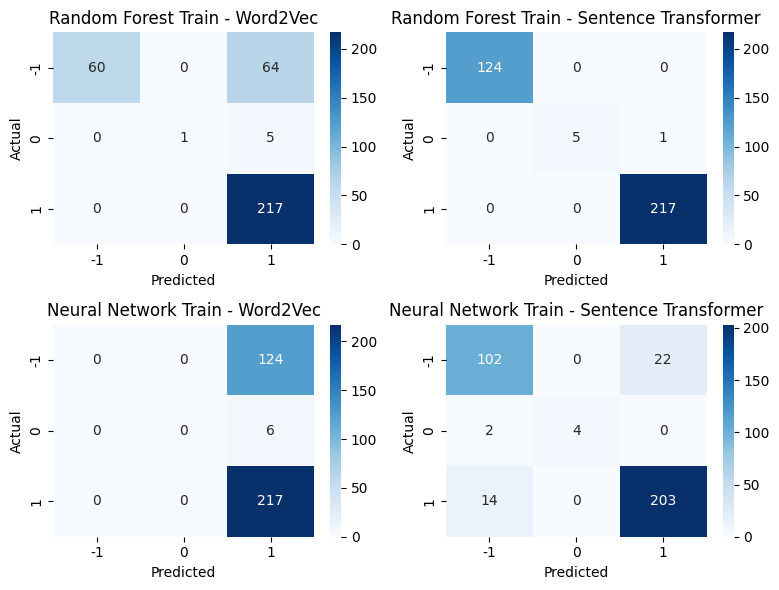

In [254]:
# All training Confusion Matrix
actual = y_train
predicted = [y_train_pred_rf_wv_model4, y_train_pred_rf_st_model4, y_train_pred_nn_wv_argmax_model4, y_train_pred_nn_st_argmax_model4]
titles = ['Random Forest Train - Word2Vec', 'Random Forest Train - Sentence Transformer', 'Neural Network Train - Word2Vec', 'Neural Network Train - Sentence Transformer']
plot_confusion_matrix_multiple(actual, predicted, titles)

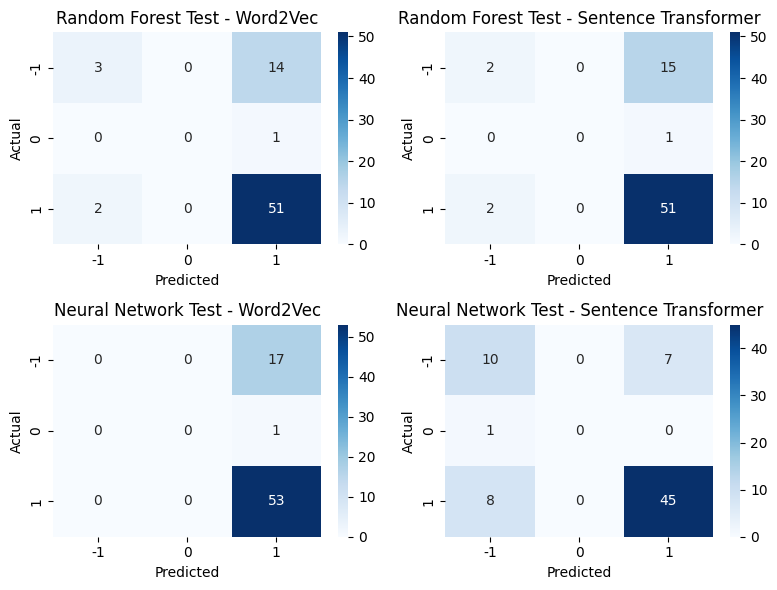

In [255]:
# All testing Confusion Matrix
actual = y_test
predicted = [y_test_pred_rf_wv_model4, y_test_pred_rf_st_model2, y_test_pred_nn_wv_argmax_model4, y_test_pred_nn_st_argmax_model4]
titles = ['Random Forest Test - Word2Vec', 'Random Forest Test - Sentence Transformer', 'Neural Network Test - Word2Vec', 'Neural Network Test - Sentence Transformer']
plot_confusion_matrix_multiple(actual, predicted, titles)

**Summary of Classification Matrix**
* Word2Vec model struggles to find the negative sentiments accuratley
* Both Word2Vec and sentence transformer models fails to identify the neutral sentiments.
* Sentence Transformer models are performing better. The Random Forest model seems to have more predictions that are correct when using sentence transformer embeddings as compared to neural networks
* Target variable with neutral sentiments are more accurately identified for neutral sentiments. It fails though with unseen data (test)
* The inability to identify the neatral cases may be is due to less number of training cases with neutral sentiments

In [270]:
# All the Evaluation Metrics of the best models put together
eval_metrics_all_models = pd.concat([eval_rf_wv_transformer,eval_rf_st_transformer,eval_nn_wv_transformer,eval_nn_st_transformer], ignore_index=True)
final_model_selected = ['Model_4_Random Forest Word2Vec', 'Model_2_Random Forest Sentence Transformer', 'Model_4_Neural Network Word2Vec', 'Model_4_Neural Network Sentence Transformer']
eval_metrics_final_models = eval_metrics_all_models[eval_metrics_all_models['Model'].isin(final_model_selected)]
eval_metrics_final_models[['Model', 'Type', 'Hyperparameters', 'Accuracy',	'Recall',	'Precision',	'F1']].sort_values(by=['Model', 'Type'])
eval_metrics_final_models

,Accuracy,Recall,Precision,F1,Model,Type,Hyperparameters
3,0.8012,0.8012,0.8491,0.7776,Model_4_Random Forest Word2Vec,Train,"{'n_estimators': 300, 'max_depth': 5}"
7,0.7606,0.7606,0.7205,0.7051,Model_4_Random Forest Word2Vec,Test,"{'n_estimators': 300, 'max_depth': 5}"
9,0.9510,0.9510,0.9373,0.9426,Model_2_Random Forest Sentence Transformer,Train,"{'n_estimators': 100, 'max_depth': 5}"
13,0.7465,0.7465,0.6879,0.6801,Model_2_Random Forest Sentence Transformer,Test,"{'n_estimators': 100, 'max_depth': 5}"
19,0.6254,0.6254,0.3911,0.4812,Model_4_Neural Network Word2Vec,Train,"{'Dense': 64, 'Dropout': 0.4, 'activation': ['..."
23,0.7465,0.7465,0.5572,0.6381,Model_4_Neural Network Word2Vec,Test,"{'Dense': 64, 'Dropout': 0.4, 'activation': ['..."
27,0.8905,0.8905,0.8904,0.8895,Model_4_Neural Network Sentence Transformer,Train,"{'Dense': (128, 64), 'Dropout': 0.4, 'activati..."
32,0.7746,0.7746,0.7720,0.7729,Model_4_Neural Network Sentence Transformer,Test,"{'Dense': (128, 64), 'Dropout': 0.4, 'activati..."


In [271]:
eval_metrics_all_models

,Accuracy,Recall,Precision,F1,Model,Type,Hyperparameters
0,0.7147,0.7147,0.7868,0.6521,Model_1_Random Forest Word2Vec,Train,"{'n_estimators': 100, 'max_depth': 3}"
1,0.8012,0.8012,0.8491,0.7786,Model_2_Random Forest Word2Vec,Train,"{'n_estimators': 100, 'max_depth': 5}"
2,0.8012,0.8012,0.8491,0.7776,Model_3_Random Forest Word2Vec,Train,"{'n_estimators': 200, 'max_depth': 5}"
3,0.8012,0.8012,0.8491,0.7776,Model_4_Random Forest Word2Vec,Train,"{'n_estimators': 300, 'max_depth': 5}"
4,0.7324,0.7324,0.6741,0.6851,Model_1_Random Forest Word2Vec,Test,"{'n_estimators': 100, 'max_depth': 3}"
5,0.7324,0.7324,0.6613,0.6708,Model_2_Random Forest Word2Vec,Test,"{'n_estimators': 100, 'max_depth': 5}"
6,0.7465,0.7465,0.6879,0.6801,Model_3_Random Forest Word2Vec,Test,"{'n_estimators': 200, 'max_depth': 5}"
7,0.7606,0.7606,0.7205,0.7051,Model_4_Random Forest Word2Vec,Test,"{'n_estimators': 300, 'max_depth': 5}"
8,0.8012,0.8012,0.8318,0.7752,Model_1_Random Forest Sentence Transformer,Train,"{'n_estimators': 100, 'max_depth': 3}"
9,0.9510,0.9510,0.9373,0.9426,Model_2_Random Forest Sentence Transformer,Train,"{'n_estimators': 100, 'max_depth': 5}"


**Summary of Evaluation:**


*   Among all the models we trained, the **Neural Network - Sentence Transformer (Model_4_Neural Network Sentence Transformer)** is showing better precision, recall and f1 score compared to others.
* The selected model seems to provide more consistent performance across training and test sets
*   Word2Vec models trained using Random Forest and Neural Network are not performing well enough.





## **Conclusions and Recommendations**

**Conclusions**

1. **Random Forest - Word2Vec**

   * With optimizing the hyperparameters, reasonably good performance was able to be achieved for Word2Vec model. Adding more eestimatos and increasing the tree depth helped in improving the predictions.

2. **Random Forest - Sentence Transformer**

   * This model is also getting us almost the same result. This model shows some improvement with the aspect that we dont need to train a complex model to achieve the same result.

3. **Neural Network - Word2Vec:**

   * The Neural Network model with word2vec embeddings seems not to learn probably becuase of imbalanced data. The performance seems to be halted. Increasing the dense layers, neurons and epochs does not seem to help

4. **Neural Network - Sentence Transformer**

   * This model seems to perform relatively better, but still the recall percentage cannot be achieved more than 76%. It might have something to do with the data set.
   * Less complex models are performing better, but it has been very challenging to imporve the prediction beyond a cetrain limit. The loss and recall is falttening after a few epochs of training.

**Recommendations**
   * Need more data to train the models that might help with improving the predictions.
   * The data is highly imbalanced. Need more scenarios when the sentiments are neutral spread across multiple dates

<font size=6 color='blue'>Power Ahead</font>
___